In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
from scipy.integrate import quad, fixed_quad
import matplotlib.pyplot as plt
import pickle
import numpy as np
import functools
import sys
from tqdm import tqdm, trange
from aemulusnu_massfunction.utils import *
from aemulusnu_massfunction.emulator import *

from classy import Class

import math
import torch
import gpytorch
from matplotlib import pyplot as plt

import pyccl as ccl


In [3]:

cosmos_f = open('../data/cosmo_params.pkl', 'rb')
cosmo_params = pickle.load(cosmos_f) #cosmo_params is a dict
cosmos_f.close()

a_list_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/alist.pkl'
a_list_f = open(a_list_fname, 'rb')
a_list = pickle.load(a_list_f)
a_list_f.close()

In [13]:
weird_boxes = []


errors = {a:{} for a in a_list}
X = []
Y = []
z_to_a = {}
a_to_z = {}
kt = np.logspace(-3, 1, 100) # h/Mpc
for box in tqdm(cosmo_params):
    if(box in weird_boxes):
        continue
    curr_cosmo = cosmo_params[box]
    if(box == 'Box_n50_0_1400'):
        print(curr_cosmo)

    curr_cosmo_values = [curr_cosmo[curr_key] for curr_key in key_ordering]

    h = curr_cosmo['H0']/100

    Ωb =  curr_cosmo['ombh2'] / h**2
    Ωc =  curr_cosmo['omch2'] / h**2

    cosmo = ccl.Cosmology(Omega_c=Ωc,
                          Omega_b=Ωb,
                          h=h,
                          A_s=curr_cosmo['10^9 As']*10**(-9),
                          n_s=curr_cosmo['ns'],
                          w0=curr_cosmo['w0'],
                          m_nu=[curr_cosmo['nu_mass_ev']/3, curr_cosmo['nu_mass_ev']/3, curr_cosmo['nu_mass_ev']/3])


    try:
        with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_params.pkl"%(box), "rb") as f:
            MLE_params = pickle.load(f)
            param_values = list(MLE_params.values())
            Y+= [param_values]
            X+= [curr_cosmo_values]
    except:
        print(box, z)
    for a in a_list:
        z = scaleToRedshift(a)
        z_to_a[z] = a
        a_to_z[a] = z

100%|██████████| 150/150 [00:00<00:00, 515.80it/s]

{'ns': 0.97000003, 'H0': 67.0, 'w0': -1.0, 'ombh2': 0.0223, 'omch2': 0.12, 'nu_mass_ev': 0.07071068, '10^9 As': 2.10100315}


In [14]:
X = np.array(X)
Y = np.array(Y)

print(X.shape)
print(Y.shape)
################################
print('scaling input')
in_scaler = Normalizer()
in_scaler.fit(X)
X = in_scaler.transform(X)
print(X.shape)


print('scaling output')
out_scaler = Standardizer()
out_scaler.fit(Y)
Y = out_scaler.transform(Y)
print(Y.shape)

##REMEMBER TO UNSCALE OUTPUT AND SAVE SCALERS#####

X_train = torch.from_numpy(X).float()
Y_train = torch.from_numpy(Y).float()
n_tasks = len(Y_train[0])

(150, 7)
(150, 8)
scaling input
(150, 7)
scaling output
(150, 8)


In [15]:
from aemulusnu_massfunction.emulator import *


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=n_tasks,
                                                              has_global_noise=False, 
                                                              has_task_noise=True)
model = MultitaskGPModel(X_train, Y_train, likelihood)


# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()


training_iterations = 2000

In [16]:
epochs_iter = tqdm(range(training_iterations), desc="Iteration")


# Create the optimizer with the initial learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, amsgrad=True)  # Includes GaussianLikelihood parameters

for i in epochs_iter:
    # Training step
    model.train()
    likelihood.train()

    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, Y_train)
    epochs_iter.set_postfix(loss=loss.item())
    loss.backward()
    optimizer.step()
    print('Iter %d/%d - Loss: %.4f' % (i + 1, training_iterations, loss.item()))

    # Change learning rate after half of iterations
#     if i == 250:
#         lr = 0.01
#         print('reducing lr to 0.01')
#         for param_group in optimizer.param_groups:
#             param_group['lr'] = lr

#     if i == 150:
#         lr = 0.01
#         print('reducing lr to 0.01')
#         for param_group in optimizer.param_groups:
#             param_group['lr'] = lr
#-.926

Iteration:   0%|          | 4/2000 [00:00<01:50, 18.14it/s, loss=3.26]

Iter 1/2000 - Loss: 3.3463
Iter 2/2000 - Loss: 3.3167
Iter 3/2000 - Loss: 3.2871
Iter 4/2000 - Loss: 3.2574


Iteration:   0%|          | 6/2000 [00:00<01:59, 16.73it/s, loss=3.11]

Iter 5/2000 - Loss: 3.2276
Iter 6/2000 - Loss: 3.1978
Iter 7/2000 - Loss: 3.1679
Iter 8/2000 - Loss: 3.1380


Iteration:   1%|          | 13/2000 [00:00<01:19, 24.94it/s, loss=2.84]

Iter 9/2000 - Loss: 3.1080
Iter 10/2000 - Loss: 3.0779
Iter 11/2000 - Loss: 3.0478
Iter 12/2000 - Loss: 3.0176
Iter 13/2000 - Loss: 2.9873
Iter 14/2000 - Loss: 2.9570
Iter 15/2000 - Loss: 2.9267
Iter 16/2000 - Loss: 2.8963
Iter 17/2000 - Loss: 2.8658


Iteration:   1%|          | 24/2000 [00:00<00:52, 37.70it/s, loss=2.53]

Iter 18/2000 - Loss: 2.8354
Iter 19/2000 - Loss: 2.8049
Iter 20/2000 - Loss: 2.7743
Iter 21/2000 - Loss: 2.7438
Iter 22/2000 - Loss: 2.7133
Iter 23/2000 - Loss: 2.6827
Iter 24/2000 - Loss: 2.6522
Iter 25/2000 - Loss: 2.6218
Iter 26/2000 - Loss: 2.5913
Iter 27/2000 - Loss: 2.5609


Iteration:   2%|▏         | 35/2000 [00:01<00:48, 40.44it/s, loss=2.32]

Iter 28/2000 - Loss: 2.5306
Iter 29/2000 - Loss: 2.5004
Iter 30/2000 - Loss: 2.4703
Iter 31/2000 - Loss: 2.4402
Iter 32/2000 - Loss: 2.4103
Iter 33/2000 - Loss: 2.3805
Iter 34/2000 - Loss: 2.3509
Iter 35/2000 - Loss: 2.3214


Iteration:   2%|▏         | 40/2000 [00:01<00:58, 33.39it/s, loss=2.12]

Iter 36/2000 - Loss: 2.2921
Iter 37/2000 - Loss: 2.2629
Iter 38/2000 - Loss: 2.2339
Iter 39/2000 - Loss: 2.2051
Iter 40/2000 - Loss: 2.1765
Iter 41/2000 - Loss: 2.1481
Iter 42/2000 - Loss: 2.1198


Iteration:   2%|▏         | 44/2000 [00:01<01:01, 31.85it/s, loss=2.01]

Iter 43/2000 - Loss: 2.0918
Iter 44/2000 - Loss: 2.0640
Iter 45/2000 - Loss: 2.0363


Iteration:   2%|▏         | 48/2000 [00:01<01:26, 22.59it/s, loss=1.93]

Iter 46/2000 - Loss: 2.0089
Iter 47/2000 - Loss: 1.9817
Iter 48/2000 - Loss: 1.9547
Iter 49/2000 - Loss: 1.9280


Iteration:   2%|▏         | 48/2000 [00:01<01:26, 22.59it/s, loss=1.9] 

Iter 50/2000 - Loss: 1.9015


Iteration:   3%|▎         | 51/2000 [00:02<02:25, 13.37it/s, loss=1.85]

Iter 51/2000 - Loss: 1.8753
Iter 52/2000 - Loss: 1.8493


Iteration:   3%|▎         | 58/2000 [00:02<02:05, 15.44it/s, loss=1.65]

Iter 53/2000 - Loss: 1.8236
Iter 54/2000 - Loss: 1.7983
Iter 55/2000 - Loss: 1.7732
Iter 56/2000 - Loss: 1.7484
Iter 57/2000 - Loss: 1.7240
Iter 58/2000 - Loss: 1.7000
Iter 59/2000 - Loss: 1.6763
Iter 60/2000 - Loss: 1.6529


Iteration:   3%|▎         | 66/2000 [00:02<01:32, 20.84it/s, loss=1.52]

Iter 61/2000 - Loss: 1.6299
Iter 62/2000 - Loss: 1.6073
Iter 63/2000 - Loss: 1.5851
Iter 64/2000 - Loss: 1.5633
Iter 65/2000 - Loss: 1.5418
Iter 66/2000 - Loss: 1.5208


Iteration:   4%|▎         | 72/2000 [00:03<01:10, 27.45it/s, loss=1.32]

Iter 67/2000 - Loss: 1.5002
Iter 68/2000 - Loss: 1.4800
Iter 69/2000 - Loss: 1.4602
Iter 70/2000 - Loss: 1.4408
Iter 71/2000 - Loss: 1.4218
Iter 72/2000 - Loss: 1.4033
Iter 73/2000 - Loss: 1.3852
Iter 74/2000 - Loss: 1.3675
Iter 75/2000 - Loss: 1.3503
Iter 76/2000 - Loss: 1.3336
Iter 77/2000 - Loss: 1.3173


Iteration:   4%|▍         | 78/2000 [00:03<00:58, 33.06it/s, loss=1.24]

Iter 78/2000 - Loss: 1.3014
Iter 79/2000 - Loss: 1.2860
Iter 80/2000 - Loss: 1.2711
Iter 81/2000 - Loss: 1.2567
Iter 82/2000 - Loss: 1.2427


Iteration:   4%|▍         | 83/2000 [00:03<01:21, 23.66it/s, loss=1.22]

Iter 83/2000 - Loss: 1.2292


Iteration:   4%|▍         | 87/2000 [00:03<01:42, 18.58it/s, loss=1.15]

Iter 84/2000 - Loss: 1.2161
Iter 85/2000 - Loss: 1.2036
Iter 86/2000 - Loss: 1.1916
Iter 87/2000 - Loss: 1.1800
Iter 88/2000 - Loss: 1.1689
Iter 89/2000 - Loss: 1.1583


Iteration:   5%|▍         | 93/2000 [00:04<01:28, 21.46it/s, loss=1.12]

Iter 90/2000 - Loss: 1.1482
Iter 91/2000 - Loss: 1.1386
Iter 92/2000 - Loss: 1.1295
Iter 93/2000 - Loss: 1.1208


Iteration:   5%|▍         | 96/2000 [00:04<01:33, 20.42it/s, loss=1.08]

Iter 94/2000 - Loss: 1.1125
Iter 95/2000 - Loss: 1.1047
Iter 96/2000 - Loss: 1.0973
Iter 97/2000 - Loss: 1.0902
Iter 98/2000 - Loss: 1.0836


Iteration:   5%|▌         | 105/2000 [00:04<01:07, 28.28it/s, loss=1.03]

Iter 99/2000 - Loss: 1.0773
Iter 100/2000 - Loss: 1.0713
Iter 101/2000 - Loss: 1.0657
Iter 102/2000 - Loss: 1.0603
Iter 103/2000 - Loss: 1.0552
Iter 104/2000 - Loss: 1.0503
Iter 105/2000 - Loss: 1.0457
Iter 106/2000 - Loss: 1.0413
Iter 107/2000 - Loss: 1.0371
Iter 108/2000 - Loss: 1.0331


Iteration:   6%|▌         | 115/2000 [00:04<00:52, 35.77it/s, loss=1]   

Iter 109/2000 - Loss: 1.0292
Iter 110/2000 - Loss: 1.0255
Iter 111/2000 - Loss: 1.0219
Iter 112/2000 - Loss: 1.0184
Iter 113/2000 - Loss: 1.0151
Iter 114/2000 - Loss: 1.0119
Iter 115/2000 - Loss: 1.0087
Iter 116/2000 - Loss: 1.0057
Iter 117/2000 - Loss: 1.0027


Iteration:   6%|▋         | 125/2000 [00:04<00:48, 38.29it/s, loss=0.975]

Iter 118/2000 - Loss: 0.9999
Iter 119/2000 - Loss: 0.9971
Iter 120/2000 - Loss: 0.9944
Iter 121/2000 - Loss: 0.9917
Iter 122/2000 - Loss: 0.9891
Iter 123/2000 - Loss: 0.9866
Iter 124/2000 - Loss: 0.9842
Iter 125/2000 - Loss: 0.9818
Iter 126/2000 - Loss: 0.9795
Iter 127/2000 - Loss: 0.9772


Iteration:   7%|▋         | 138/2000 [00:05<00:38, 48.97it/s, loss=0.952]

Iter 128/2000 - Loss: 0.9750
Iter 129/2000 - Loss: 0.9729
Iter 130/2000 - Loss: 0.9708
Iter 131/2000 - Loss: 0.9687
Iter 132/2000 - Loss: 0.9667
Iter 133/2000 - Loss: 0.9648
Iter 134/2000 - Loss: 0.9629
Iter 135/2000 - Loss: 0.9610
Iter 136/2000 - Loss: 0.9592
Iter 137/2000 - Loss: 0.9574
Iter 138/2000 - Loss: 0.9557
Iter 139/2000 - Loss: 0.9540
Iter 140/2000 - Loss: 0.9524


Iteration:   7%|▋         | 138/2000 [00:05<00:38, 48.97it/s, loss=0.948]

Iter 141/2000 - Loss: 0.9508
Iter 142/2000 - Loss: 0.9492
Iter 143/2000 - Loss: 0.9476


Iteration:   7%|▋         | 144/2000 [00:05<00:50, 36.65it/s, loss=0.945]

Iter 144/2000 - Loss: 0.9461
Iter 145/2000 - Loss: 0.9446


Iteration:   7%|▋         | 149/2000 [00:05<01:17, 23.86it/s, loss=0.939]

Iter 146/2000 - Loss: 0.9432
Iter 147/2000 - Loss: 0.9417
Iter 148/2000 - Loss: 0.9403
Iter 149/2000 - Loss: 0.9389


Iteration:   8%|▊         | 153/2000 [00:06<01:22, 22.36it/s, loss=0.93] 

Iter 150/2000 - Loss: 0.9376
Iter 151/2000 - Loss: 0.9363
Iter 152/2000 - Loss: 0.9350
Iter 153/2000 - Loss: 0.9337
Iter 154/2000 - Loss: 0.9324
Iter 155/2000 - Loss: 0.9312
Iter 156/2000 - Loss: 0.9299


Iteration:   8%|▊         | 158/2000 [00:06<01:10, 26.12it/s, loss=0.923]

Iter 157/2000 - Loss: 0.9287
Iter 158/2000 - Loss: 0.9275
Iter 159/2000 - Loss: 0.9264
Iter 160/2000 - Loss: 0.9252
Iter 161/2000 - Loss: 0.9241


Iteration:   8%|▊         | 169/2000 [00:06<00:55, 32.74it/s, loss=0.913]

Iter 162/2000 - Loss: 0.9230
Iter 163/2000 - Loss: 0.9219
Iter 164/2000 - Loss: 0.9208
Iter 165/2000 - Loss: 0.9197
Iter 166/2000 - Loss: 0.9186
Iter 167/2000 - Loss: 0.9176
Iter 168/2000 - Loss: 0.9165
Iter 169/2000 - Loss: 0.9155
Iter 170/2000 - Loss: 0.9145
Iter 171/2000 - Loss: 0.9135


Iteration:   9%|▉         | 179/2000 [00:06<00:48, 37.64it/s, loss=0.901]

Iter 172/2000 - Loss: 0.9125
Iter 173/2000 - Loss: 0.9115
Iter 174/2000 - Loss: 0.9106
Iter 175/2000 - Loss: 0.9096
Iter 176/2000 - Loss: 0.9086
Iter 177/2000 - Loss: 0.9077
Iter 178/2000 - Loss: 0.9068
Iter 179/2000 - Loss: 0.9059
Iter 180/2000 - Loss: 0.9049
Iter 181/2000 - Loss: 0.9040
Iter 182/2000 - Loss: 0.9031
Iter 183/2000 - Loss: 0.9022


Iteration:  10%|▉         | 193/2000 [00:06<00:37, 48.66it/s, loss=0.891]

Iter 184/2000 - Loss: 0.9014
Iter 185/2000 - Loss: 0.9005
Iter 186/2000 - Loss: 0.8996
Iter 187/2000 - Loss: 0.8988
Iter 188/2000 - Loss: 0.8979
Iter 189/2000 - Loss: 0.8971
Iter 190/2000 - Loss: 0.8962
Iter 191/2000 - Loss: 0.8954
Iter 192/2000 - Loss: 0.8946
Iter 193/2000 - Loss: 0.8937
Iter 194/2000 - Loss: 0.8929
Iter 195/2000 - Loss: 0.8921


Iteration:  10%|█         | 205/2000 [00:07<00:37, 48.28it/s, loss=0.884]

Iter 196/2000 - Loss: 0.8913
Iter 197/2000 - Loss: 0.8905
Iter 198/2000 - Loss: 0.8897
Iter 199/2000 - Loss: 0.8889
Iter 200/2000 - Loss: 0.8881
Iter 201/2000 - Loss: 0.8874
Iter 202/2000 - Loss: 0.8866
Iter 203/2000 - Loss: 0.8858
Iter 204/2000 - Loss: 0.8850
Iter 205/2000 - Loss: 0.8843


Iteration:  11%|█         | 212/2000 [00:07<00:34, 52.16it/s, loss=0.877]

Iter 206/2000 - Loss: 0.8835
Iter 207/2000 - Loss: 0.8827
Iter 208/2000 - Loss: 0.8820
Iter 209/2000 - Loss: 0.8812
Iter 210/2000 - Loss: 0.8805
Iter 211/2000 - Loss: 0.8797
Iter 212/2000 - Loss: 0.8790
Iter 213/2000 - Loss: 0.8783
Iter 214/2000 - Loss: 0.8775
Iter 215/2000 - Loss: 0.8768


Iteration:  11%|█         | 218/2000 [00:07<00:48, 37.11it/s, loss=0.872]

Iter 216/2000 - Loss: 0.8761
Iter 217/2000 - Loss: 0.8753
Iter 218/2000 - Loss: 0.8746
Iter 219/2000 - Loss: 0.8739
Iter 220/2000 - Loss: 0.8731
Iter 221/2000 - Loss: 0.8724


Iteration:  12%|█▏        | 232/2000 [00:07<00:37, 47.36it/s, loss=0.863]

Iter 222/2000 - Loss: 0.8717
Iter 223/2000 - Loss: 0.8710
Iter 224/2000 - Loss: 0.8703
Iter 225/2000 - Loss: 0.8696
Iter 226/2000 - Loss: 0.8688
Iter 227/2000 - Loss: 0.8681
Iter 228/2000 - Loss: 0.8674
Iter 229/2000 - Loss: 0.8667
Iter 230/2000 - Loss: 0.8660
Iter 231/2000 - Loss: 0.8653
Iter 232/2000 - Loss: 0.8646
Iter 233/2000 - Loss: 0.8639
Iter 234/2000 - Loss: 0.8632


Iteration:  12%|█▏        | 246/2000 [00:08<00:32, 53.73it/s, loss=0.854]

Iter 235/2000 - Loss: 0.8625
Iter 236/2000 - Loss: 0.8618
Iter 237/2000 - Loss: 0.8611
Iter 238/2000 - Loss: 0.8604
Iter 239/2000 - Loss: 0.8597
Iter 240/2000 - Loss: 0.8590
Iter 241/2000 - Loss: 0.8583
Iter 242/2000 - Loss: 0.8576
Iter 243/2000 - Loss: 0.8569
Iter 244/2000 - Loss: 0.8563
Iter 245/2000 - Loss: 0.8556
Iter 246/2000 - Loss: 0.8549
Iter 247/2000 - Loss: 0.8542


Iteration:  13%|█▎        | 252/2000 [00:08<00:39, 44.78it/s, loss=0.849]

Iter 248/2000 - Loss: 0.8535
Iter 249/2000 - Loss: 0.8528
Iter 250/2000 - Loss: 0.8521
Iter 251/2000 - Loss: 0.8514
Iter 252/2000 - Loss: 0.8507
Iter 253/2000 - Loss: 0.8501
Iter 254/2000 - Loss: 0.8494


Iteration:  13%|█▎        | 265/2000 [00:08<00:33, 51.50it/s, loss=0.842]

Iter 255/2000 - Loss: 0.8487
Iter 256/2000 - Loss: 0.8480
Iter 257/2000 - Loss: 0.8473
Iter 258/2000 - Loss: 0.8466
Iter 259/2000 - Loss: 0.8460
Iter 260/2000 - Loss: 0.8453
Iter 261/2000 - Loss: 0.8446
Iter 262/2000 - Loss: 0.8439
Iter 263/2000 - Loss: 0.8432
Iter 264/2000 - Loss: 0.8425
Iter 265/2000 - Loss: 0.8419


Iteration:  14%|█▎        | 271/2000 [00:08<00:38, 44.65it/s, loss=0.834]

Iter 266/2000 - Loss: 0.8412
Iter 267/2000 - Loss: 0.8405
Iter 268/2000 - Loss: 0.8398
Iter 269/2000 - Loss: 0.8391
Iter 270/2000 - Loss: 0.8385
Iter 271/2000 - Loss: 0.8378
Iter 272/2000 - Loss: 0.8371
Iter 273/2000 - Loss: 0.8364
Iter 274/2000 - Loss: 0.8357
Iter 275/2000 - Loss: 0.8351
Iter 276/2000 - Loss: 0.8344
Iter 277/2000 - Loss: 0.8337


Iteration:  14%|█▍        | 285/2000 [00:08<00:32, 52.42it/s, loss=0.826]

Iter 278/2000 - Loss: 0.8330
Iter 279/2000 - Loss: 0.8324
Iter 280/2000 - Loss: 0.8317
Iter 281/2000 - Loss: 0.8310
Iter 282/2000 - Loss: 0.8303
Iter 283/2000 - Loss: 0.8297
Iter 284/2000 - Loss: 0.8290
Iter 285/2000 - Loss: 0.8283
Iter 286/2000 - Loss: 0.8276
Iter 287/2000 - Loss: 0.8270
Iter 288/2000 - Loss: 0.8263


Iteration:  15%|█▍        | 291/2000 [00:09<00:35, 48.28it/s, loss=0.823]

Iter 289/2000 - Loss: 0.8256
Iter 290/2000 - Loss: 0.8250
Iter 291/2000 - Loss: 0.8243
Iter 292/2000 - Loss: 0.8236
Iter 293/2000 - Loss: 0.8230


Iteration:  15%|█▍        | 297/2000 [00:09<00:46, 36.62it/s, loss=0.817]

Iter 294/2000 - Loss: 0.8223
Iter 295/2000 - Loss: 0.8216
Iter 296/2000 - Loss: 0.8210
Iter 297/2000 - Loss: 0.8203
Iter 298/2000 - Loss: 0.8196
Iter 299/2000 - Loss: 0.8190
Iter 300/2000 - Loss: 0.8183
Iter 301/2000 - Loss: 0.8177
Iter 302/2000 - Loss: 0.8170


Iteration:  16%|█▌        | 310/2000 [00:09<00:37, 45.65it/s, loss=0.809]

Iter 303/2000 - Loss: 0.8163
Iter 304/2000 - Loss: 0.8157
Iter 305/2000 - Loss: 0.8150
Iter 306/2000 - Loss: 0.8144
Iter 307/2000 - Loss: 0.8137
Iter 308/2000 - Loss: 0.8131
Iter 309/2000 - Loss: 0.8124
Iter 310/2000 - Loss: 0.8118
Iter 311/2000 - Loss: 0.8111
Iter 312/2000 - Loss: 0.8105
Iter 313/2000 - Loss: 0.8098
Iter 314/2000 - Loss: 0.8092
Iter 315/2000 - Loss: 0.8086


Iteration:  16%|█▌        | 323/2000 [00:09<00:37, 45.03it/s, loss=0.803]

Iter 316/2000 - Loss: 0.8079
Iter 317/2000 - Loss: 0.8073
Iter 318/2000 - Loss: 0.8066
Iter 319/2000 - Loss: 0.8060
Iter 320/2000 - Loss: 0.8054
Iter 321/2000 - Loss: 0.8047
Iter 322/2000 - Loss: 0.8041
Iter 323/2000 - Loss: 0.8035
Iter 324/2000 - Loss: 0.8029


Iteration:  16%|█▋        | 328/2000 [00:09<00:42, 39.45it/s, loss=0.799]

Iter 325/2000 - Loss: 0.8022
Iter 326/2000 - Loss: 0.8016
Iter 327/2000 - Loss: 0.8010
Iter 328/2000 - Loss: 0.8004
Iter 329/2000 - Loss: 0.7997
Iter 330/2000 - Loss: 0.7991
Iter 331/2000 - Loss: 0.7985


Iteration:  17%|█▋        | 340/2000 [00:10<00:36, 45.25it/s, loss=0.792]

Iter 332/2000 - Loss: 0.7979
Iter 333/2000 - Loss: 0.7973
Iter 334/2000 - Loss: 0.7967
Iter 335/2000 - Loss: 0.7961
Iter 336/2000 - Loss: 0.7955
Iter 337/2000 - Loss: 0.7949
Iter 338/2000 - Loss: 0.7943
Iter 339/2000 - Loss: 0.7937
Iter 340/2000 - Loss: 0.7931
Iter 341/2000 - Loss: 0.7925
Iter 342/2000 - Loss: 0.7919


Iteration:  18%|█▊        | 351/2000 [00:10<00:37, 44.43it/s, loss=0.786]

Iter 343/2000 - Loss: 0.7913
Iter 344/2000 - Loss: 0.7907
Iter 345/2000 - Loss: 0.7901
Iter 346/2000 - Loss: 0.7896
Iter 347/2000 - Loss: 0.7890
Iter 348/2000 - Loss: 0.7884
Iter 349/2000 - Loss: 0.7878
Iter 350/2000 - Loss: 0.7872
Iter 351/2000 - Loss: 0.7867


Iteration:  18%|█▊        | 357/2000 [00:10<00:34, 47.18it/s, loss=0.781]

Iter 352/2000 - Loss: 0.7861
Iter 353/2000 - Loss: 0.7855
Iter 354/2000 - Loss: 0.7850
Iter 355/2000 - Loss: 0.7844
Iter 356/2000 - Loss: 0.7839
Iter 357/2000 - Loss: 0.7833
Iter 358/2000 - Loss: 0.7828
Iter 359/2000 - Loss: 0.7822
Iter 360/2000 - Loss: 0.7817
Iter 361/2000 - Loss: 0.7811
Iter 362/2000 - Loss: 0.7806


Iteration:  18%|█▊        | 369/2000 [00:10<00:33, 49.16it/s, loss=0.775]

Iter 363/2000 - Loss: 0.7800
Iter 364/2000 - Loss: 0.7795
Iter 365/2000 - Loss: 0.7790
Iter 366/2000 - Loss: 0.7784
Iter 367/2000 - Loss: 0.7779
Iter 368/2000 - Loss: 0.7774
Iter 369/2000 - Loss: 0.7768
Iter 370/2000 - Loss: 0.7763
Iter 371/2000 - Loss: 0.7758
Iter 372/2000 - Loss: 0.7753


Iteration:  19%|█▉        | 381/2000 [00:10<00:30, 52.44it/s, loss=0.769]

Iter 373/2000 - Loss: 0.7748
Iter 374/2000 - Loss: 0.7743
Iter 375/2000 - Loss: 0.7738
Iter 376/2000 - Loss: 0.7732
Iter 377/2000 - Loss: 0.7727
Iter 378/2000 - Loss: 0.7722
Iter 379/2000 - Loss: 0.7717
Iter 380/2000 - Loss: 0.7713
Iter 381/2000 - Loss: 0.7708
Iter 382/2000 - Loss: 0.7703
Iter 383/2000 - Loss: 0.7698
Iter 384/2000 - Loss: 0.7693


Iteration:  20%|█▉        | 394/2000 [00:11<00:34, 46.68it/s, loss=0.765]

Iter 385/2000 - Loss: 0.7688
Iter 386/2000 - Loss: 0.7683
Iter 387/2000 - Loss: 0.7679
Iter 388/2000 - Loss: 0.7674
Iter 389/2000 - Loss: 0.7669
Iter 390/2000 - Loss: 0.7665
Iter 391/2000 - Loss: 0.7660
Iter 392/2000 - Loss: 0.7655
Iter 393/2000 - Loss: 0.7651
Iter 394/2000 - Loss: 0.7646


Iteration:  20%|█▉        | 394/2000 [00:11<00:34, 46.68it/s, loss=0.763]

Iter 395/2000 - Loss: 0.7642
Iter 396/2000 - Loss: 0.7637
Iter 397/2000 - Loss: 0.7633
Iter 398/2000 - Loss: 0.7628


Iteration:  20%|██        | 406/2000 [00:11<00:43, 36.30it/s, loss=0.758]

Iter 399/2000 - Loss: 0.7624
Iter 400/2000 - Loss: 0.7620
Iter 401/2000 - Loss: 0.7615
Iter 402/2000 - Loss: 0.7611
Iter 403/2000 - Loss: 0.7607
Iter 404/2000 - Loss: 0.7602
Iter 405/2000 - Loss: 0.7598
Iter 406/2000 - Loss: 0.7594
Iter 407/2000 - Loss: 0.7590
Iter 408/2000 - Loss: 0.7586


Iteration:  21%|██        | 413/2000 [00:11<00:37, 41.89it/s, loss=0.755]

Iter 409/2000 - Loss: 0.7582
Iter 410/2000 - Loss: 0.7578
Iter 411/2000 - Loss: 0.7574
Iter 412/2000 - Loss: 0.7570
Iter 413/2000 - Loss: 0.7566
Iter 414/2000 - Loss: 0.7562
Iter 415/2000 - Loss: 0.7558
Iter 416/2000 - Loss: 0.7554
Iter 417/2000 - Loss: 0.7550


Iteration:  21%|██▏       | 426/2000 [00:12<00:34, 45.29it/s, loss=0.75] 

Iter 418/2000 - Loss: 0.7546
Iter 419/2000 - Loss: 0.7542
Iter 420/2000 - Loss: 0.7539
Iter 421/2000 - Loss: 0.7535
Iter 422/2000 - Loss: 0.7531
Iter 423/2000 - Loss: 0.7527
Iter 424/2000 - Loss: 0.7524
Iter 425/2000 - Loss: 0.7520
Iter 426/2000 - Loss: 0.7517
Iter 427/2000 - Loss: 0.7513
Iter 428/2000 - Loss: 0.7510
Iter 429/2000 - Loss: 0.7506
Iter 430/2000 - Loss: 0.7503


Iteration:  22%|██▏       | 439/2000 [00:12<00:30, 51.51it/s, loss=0.747]

Iter 431/2000 - Loss: 0.7499
Iter 432/2000 - Loss: 0.7496
Iter 433/2000 - Loss: 0.7492
Iter 434/2000 - Loss: 0.7489
Iter 435/2000 - Loss: 0.7486
Iter 436/2000 - Loss: 0.7483
Iter 437/2000 - Loss: 0.7479
Iter 438/2000 - Loss: 0.7476
Iter 439/2000 - Loss: 0.7473
Iter 440/2000 - Loss: 0.7470
Iter 441/2000 - Loss: 0.7467


Iteration:  23%|██▎       | 451/2000 [00:12<00:31, 49.09it/s, loss=0.743]

Iter 442/2000 - Loss: 0.7463
Iter 443/2000 - Loss: 0.7460
Iter 444/2000 - Loss: 0.7457
Iter 445/2000 - Loss: 0.7454
Iter 446/2000 - Loss: 0.7451
Iter 447/2000 - Loss: 0.7448
Iter 448/2000 - Loss: 0.7446
Iter 449/2000 - Loss: 0.7443
Iter 450/2000 - Loss: 0.7440
Iter 451/2000 - Loss: 0.7437
Iter 452/2000 - Loss: 0.7434


Iteration:  23%|██▎       | 464/2000 [00:12<00:28, 53.68it/s, loss=0.74] 

Iter 453/2000 - Loss: 0.7431
Iter 454/2000 - Loss: 0.7429
Iter 455/2000 - Loss: 0.7426
Iter 456/2000 - Loss: 0.7423
Iter 457/2000 - Loss: 0.7421
Iter 458/2000 - Loss: 0.7418
Iter 459/2000 - Loss: 0.7415
Iter 460/2000 - Loss: 0.7413
Iter 461/2000 - Loss: 0.7410
Iter 462/2000 - Loss: 0.7408
Iter 463/2000 - Loss: 0.7405
Iter 464/2000 - Loss: 0.7403


Iteration:  24%|██▎       | 471/2000 [00:13<00:27, 55.98it/s, loss=0.737]

Iter 465/2000 - Loss: 0.7400
Iter 466/2000 - Loss: 0.7398
Iter 467/2000 - Loss: 0.7396
Iter 468/2000 - Loss: 0.7393
Iter 469/2000 - Loss: 0.7391
Iter 470/2000 - Loss: 0.7389
Iter 471/2000 - Loss: 0.7386
Iter 472/2000 - Loss: 0.7384
Iter 473/2000 - Loss: 0.7382
Iter 474/2000 - Loss: 0.7380
Iter 475/2000 - Loss: 0.7378
Iter 476/2000 - Loss: 0.7375
Iter 477/2000 - Loss: 0.7373


Iteration:  24%|██▍       | 484/2000 [00:13<00:30, 49.59it/s, loss=0.735]

Iter 478/2000 - Loss: 0.7371
Iter 479/2000 - Loss: 0.7369
Iter 480/2000 - Loss: 0.7367
Iter 481/2000 - Loss: 0.7365
Iter 482/2000 - Loss: 0.7363
Iter 483/2000 - Loss: 0.7361
Iter 484/2000 - Loss: 0.7359
Iter 485/2000 - Loss: 0.7357
Iter 486/2000 - Loss: 0.7356
Iter 487/2000 - Loss: 0.7354
Iter 488/2000 - Loss: 0.7352
Iter 489/2000 - Loss: 0.7350


Iteration:  25%|██▍       | 498/2000 [00:13<00:27, 55.37it/s, loss=0.733]

Iter 490/2000 - Loss: 0.7348
Iter 491/2000 - Loss: 0.7346
Iter 492/2000 - Loss: 0.7345
Iter 493/2000 - Loss: 0.7343
Iter 494/2000 - Loss: 0.7341
Iter 495/2000 - Loss: 0.7340
Iter 496/2000 - Loss: 0.7338
Iter 497/2000 - Loss: 0.7336
Iter 498/2000 - Loss: 0.7335
Iter 499/2000 - Loss: 0.7333
Iter 500/2000 - Loss: 0.7332


Iteration:  26%|██▌       | 511/2000 [00:13<00:26, 55.30it/s, loss=0.732]

Iter 501/2000 - Loss: 0.7330
Iter 502/2000 - Loss: 0.7328
Iter 503/2000 - Loss: 0.7327
Iter 504/2000 - Loss: 0.7325
Iter 505/2000 - Loss: 0.7324
Iter 506/2000 - Loss: 0.7323
Iter 507/2000 - Loss: 0.7321
Iter 508/2000 - Loss: 0.7320
Iter 509/2000 - Loss: 0.7318
Iter 510/2000 - Loss: 0.7317
Iter 511/2000 - Loss: 0.7316


Iteration:  26%|██▌       | 523/2000 [00:13<00:29, 49.38it/s, loss=0.73] 

Iter 512/2000 - Loss: 0.7314
Iter 513/2000 - Loss: 0.7313
Iter 514/2000 - Loss: 0.7312
Iter 515/2000 - Loss: 0.7310
Iter 516/2000 - Loss: 0.7309
Iter 517/2000 - Loss: 0.7308
Iter 518/2000 - Loss: 0.7307
Iter 519/2000 - Loss: 0.7306
Iter 520/2000 - Loss: 0.7304
Iter 521/2000 - Loss: 0.7303
Iter 522/2000 - Loss: 0.7302
Iter 523/2000 - Loss: 0.7301


Iteration:  26%|██▋       | 529/2000 [00:14<00:28, 51.52it/s, loss=0.729]

Iter 524/2000 - Loss: 0.7300
Iter 525/2000 - Loss: 0.7299
Iter 526/2000 - Loss: 0.7298
Iter 527/2000 - Loss: 0.7296
Iter 528/2000 - Loss: 0.7295
Iter 529/2000 - Loss: 0.7294
Iter 530/2000 - Loss: 0.7293
Iter 531/2000 - Loss: 0.7292


Iteration:  27%|██▋       | 542/2000 [00:14<00:29, 48.81it/s, loss=0.728]

Iter 532/2000 - Loss: 0.7291
Iter 533/2000 - Loss: 0.7290
Iter 534/2000 - Loss: 0.7289
Iter 535/2000 - Loss: 0.7288
Iter 536/2000 - Loss: 0.7287
Iter 537/2000 - Loss: 0.7287
Iter 538/2000 - Loss: 0.7286
Iter 539/2000 - Loss: 0.7285
Iter 540/2000 - Loss: 0.7284
Iter 541/2000 - Loss: 0.7283
Iter 542/2000 - Loss: 0.7282
Iter 543/2000 - Loss: 0.7281
Iter 544/2000 - Loss: 0.7280


Iteration:  28%|██▊       | 555/2000 [00:14<00:26, 53.77it/s, loss=0.727]

Iter 545/2000 - Loss: 0.7280
Iter 546/2000 - Loss: 0.7279
Iter 547/2000 - Loss: 0.7278
Iter 548/2000 - Loss: 0.7277
Iter 549/2000 - Loss: 0.7276
Iter 550/2000 - Loss: 0.7276
Iter 551/2000 - Loss: 0.7275
Iter 552/2000 - Loss: 0.7274
Iter 553/2000 - Loss: 0.7274
Iter 554/2000 - Loss: 0.7273
Iter 555/2000 - Loss: 0.7272
Iter 556/2000 - Loss: 0.7272
Iter 557/2000 - Loss: 0.7271


Iteration:  28%|██▊       | 561/2000 [00:14<00:30, 46.48it/s, loss=0.726]

Iter 558/2000 - Loss: 0.7270
Iter 559/2000 - Loss: 0.7269
Iter 560/2000 - Loss: 0.7269
Iter 561/2000 - Loss: 0.7268
Iter 562/2000 - Loss: 0.7267
Iter 563/2000 - Loss: 0.7267
Iter 564/2000 - Loss: 0.7266
Iter 565/2000 - Loss: 0.7265


Iteration:  29%|██▊       | 574/2000 [00:15<00:27, 51.98it/s, loss=0.726]

Iter 566/2000 - Loss: 0.7265
Iter 567/2000 - Loss: 0.7264
Iter 568/2000 - Loss: 0.7264
Iter 569/2000 - Loss: 0.7263
Iter 570/2000 - Loss: 0.7262
Iter 571/2000 - Loss: 0.7262
Iter 572/2000 - Loss: 0.7261
Iter 573/2000 - Loss: 0.7261
Iter 574/2000 - Loss: 0.7260
Iter 575/2000 - Loss: 0.7260
Iter 576/2000 - Loss: 0.7259
Iter 577/2000 - Loss: 0.7259


Iteration:  29%|██▉       | 580/2000 [00:15<00:31, 44.85it/s, loss=0.725]

Iter 578/2000 - Loss: 0.7258
Iter 579/2000 - Loss: 0.7258
Iter 580/2000 - Loss: 0.7257
Iter 581/2000 - Loss: 0.7257
Iter 582/2000 - Loss: 0.7256
Iter 583/2000 - Loss: 0.7256
Iter 584/2000 - Loss: 0.7255
Iter 585/2000 - Loss: 0.7255


Iteration:  30%|██▉       | 593/2000 [00:15<00:30, 46.66it/s, loss=0.725]

Iter 586/2000 - Loss: 0.7254
Iter 587/2000 - Loss: 0.7254
Iter 588/2000 - Loss: 0.7253
Iter 589/2000 - Loss: 0.7253
Iter 590/2000 - Loss: 0.7252
Iter 591/2000 - Loss: 0.7252
Iter 592/2000 - Loss: 0.7252
Iter 593/2000 - Loss: 0.7251
Iter 594/2000 - Loss: 0.7251
Iter 595/2000 - Loss: 0.7250


Iteration:  30%|███       | 605/2000 [00:15<00:31, 44.53it/s, loss=0.725]

Iter 596/2000 - Loss: 0.7250
Iter 597/2000 - Loss: 0.7250
Iter 598/2000 - Loss: 0.7249
Iter 599/2000 - Loss: 0.7249
Iter 600/2000 - Loss: 0.7248
Iter 601/2000 - Loss: 0.7248
Iter 602/2000 - Loss: 0.7248
Iter 603/2000 - Loss: 0.7247
Iter 604/2000 - Loss: 0.7247
Iter 605/2000 - Loss: 0.7247


Iteration:  31%|███       | 611/2000 [00:15<00:29, 47.85it/s, loss=0.724]

Iter 606/2000 - Loss: 0.7246
Iter 607/2000 - Loss: 0.7246
Iter 608/2000 - Loss: 0.7246
Iter 609/2000 - Loss: 0.7245
Iter 610/2000 - Loss: 0.7245
Iter 611/2000 - Loss: 0.7245
Iter 612/2000 - Loss: 0.7244
Iter 613/2000 - Loss: 0.7244
Iter 614/2000 - Loss: 0.7244
Iter 615/2000 - Loss: 0.7243
Iter 616/2000 - Loss: 0.7243


Iteration:  31%|███       | 622/2000 [00:16<00:29, 46.73it/s, loss=0.724]

Iter 617/2000 - Loss: 0.7243
Iter 618/2000 - Loss: 0.7242
Iter 619/2000 - Loss: 0.7242
Iter 620/2000 - Loss: 0.7242
Iter 621/2000 - Loss: 0.7241
Iter 622/2000 - Loss: 0.7241
Iter 623/2000 - Loss: 0.7241


Iteration:  31%|███▏      | 627/2000 [00:16<00:33, 41.48it/s, loss=0.724]

Iter 624/2000 - Loss: 0.7241
Iter 625/2000 - Loss: 0.7240
Iter 626/2000 - Loss: 0.7240
Iter 627/2000 - Loss: 0.7240
Iter 628/2000 - Loss: 0.7239
Iter 629/2000 - Loss: 0.7239
Iter 630/2000 - Loss: 0.7239


Iteration:  32%|███▏      | 638/2000 [00:16<00:36, 37.32it/s, loss=0.724]

Iter 631/2000 - Loss: 0.7239
Iter 632/2000 - Loss: 0.7238
Iter 633/2000 - Loss: 0.7238
Iter 634/2000 - Loss: 0.7238
Iter 635/2000 - Loss: 0.7238
Iter 636/2000 - Loss: 0.7237
Iter 637/2000 - Loss: 0.7237
Iter 638/2000 - Loss: 0.7237


Iteration:  32%|███▏      | 643/2000 [00:16<00:45, 29.79it/s, loss=0.724]

Iter 639/2000 - Loss: 0.7237
Iter 640/2000 - Loss: 0.7236
Iter 641/2000 - Loss: 0.7236
Iter 642/2000 - Loss: 0.7236
Iter 643/2000 - Loss: 0.7236


Iteration:  33%|███▎      | 656/2000 [00:17<00:32, 41.29it/s, loss=0.723]

Iter 644/2000 - Loss: 0.7236
Iter 645/2000 - Loss: 0.7235
Iter 646/2000 - Loss: 0.7235
Iter 647/2000 - Loss: 0.7235
Iter 648/2000 - Loss: 0.7235
Iter 649/2000 - Loss: 0.7234
Iter 650/2000 - Loss: 0.7234
Iter 651/2000 - Loss: 0.7234
Iter 652/2000 - Loss: 0.7234
Iter 653/2000 - Loss: 0.7234
Iter 654/2000 - Loss: 0.7233
Iter 655/2000 - Loss: 0.7233
Iter 656/2000 - Loss: 0.7233


Iteration:  33%|███▎      | 661/2000 [00:17<00:31, 41.97it/s, loss=0.723]

Iter 657/2000 - Loss: 0.7233
Iter 658/2000 - Loss: 0.7233
Iter 659/2000 - Loss: 0.7232
Iter 660/2000 - Loss: 0.7232
Iter 661/2000 - Loss: 0.7232
Iter 662/2000 - Loss: 0.7232
Iter 663/2000 - Loss: 0.7232
Iter 664/2000 - Loss: 0.7231
Iter 665/2000 - Loss: 0.7231
Iter 666/2000 - Loss: 0.7231
Iter 667/2000 - Loss: 0.7231


Iteration:  34%|███▎      | 674/2000 [00:17<00:28, 45.86it/s, loss=0.723]

Iter 668/2000 - Loss: 0.7231
Iter 669/2000 - Loss: 0.7231
Iter 670/2000 - Loss: 0.7230
Iter 671/2000 - Loss: 0.7230
Iter 672/2000 - Loss: 0.7230
Iter 673/2000 - Loss: 0.7230
Iter 674/2000 - Loss: 0.7230
Iter 675/2000 - Loss: 0.7230
Iter 676/2000 - Loss: 0.7229
Iter 677/2000 - Loss: 0.7229


Iteration:  34%|███▍      | 686/2000 [00:17<00:26, 49.84it/s, loss=0.723]

Iter 678/2000 - Loss: 0.7229
Iter 679/2000 - Loss: 0.7229
Iter 680/2000 - Loss: 0.7229
Iter 681/2000 - Loss: 0.7229
Iter 682/2000 - Loss: 0.7228
Iter 683/2000 - Loss: 0.7228
Iter 684/2000 - Loss: 0.7228
Iter 685/2000 - Loss: 0.7228
Iter 686/2000 - Loss: 0.7228
Iter 687/2000 - Loss: 0.7228
Iter 688/2000 - Loss: 0.7228
Iter 689/2000 - Loss: 0.7227


Iteration:  35%|███▍      | 698/2000 [00:17<00:26, 49.80it/s, loss=0.723]

Iter 690/2000 - Loss: 0.7227
Iter 691/2000 - Loss: 0.7227
Iter 692/2000 - Loss: 0.7227
Iter 693/2000 - Loss: 0.7227
Iter 694/2000 - Loss: 0.7227
Iter 695/2000 - Loss: 0.7227
Iter 696/2000 - Loss: 0.7226
Iter 697/2000 - Loss: 0.7226
Iter 698/2000 - Loss: 0.7226
Iter 699/2000 - Loss: 0.7226


Iteration:  35%|███▌      | 704/2000 [00:18<00:28, 45.75it/s, loss=0.722]

Iter 700/2000 - Loss: 0.7226
Iter 701/2000 - Loss: 0.7226
Iter 702/2000 - Loss: 0.7226
Iter 703/2000 - Loss: 0.7225
Iter 704/2000 - Loss: 0.7225
Iter 705/2000 - Loss: 0.7225
Iter 706/2000 - Loss: 0.7225
Iter 707/2000 - Loss: 0.7225
Iter 708/2000 - Loss: 0.7225
Iter 709/2000 - Loss: 0.7225


Iteration:  36%|███▌      | 716/2000 [00:18<00:26, 48.77it/s, loss=0.722]

Iter 710/2000 - Loss: 0.7225
Iter 711/2000 - Loss: 0.7224
Iter 712/2000 - Loss: 0.7224
Iter 713/2000 - Loss: 0.7224
Iter 714/2000 - Loss: 0.7224
Iter 715/2000 - Loss: 0.7224
Iter 716/2000 - Loss: 0.7224
Iter 717/2000 - Loss: 0.7224


Iteration:  36%|███▌      | 721/2000 [00:18<00:37, 34.32it/s, loss=0.722]

Iter 718/2000 - Loss: 0.7224
Iter 719/2000 - Loss: 0.7224
Iter 720/2000 - Loss: 0.7223
Iter 721/2000 - Loss: 0.7223
Iter 722/2000 - Loss: 0.7223
Iter 723/2000 - Loss: 0.7223
Iter 724/2000 - Loss: 0.7223


Iteration:  37%|███▋      | 733/2000 [00:18<00:30, 42.11it/s, loss=0.722]

Iter 725/2000 - Loss: 0.7223
Iter 726/2000 - Loss: 0.7223
Iter 727/2000 - Loss: 0.7223
Iter 728/2000 - Loss: 0.7223
Iter 729/2000 - Loss: 0.7222
Iter 730/2000 - Loss: 0.7222
Iter 731/2000 - Loss: 0.7222
Iter 732/2000 - Loss: 0.7222
Iter 733/2000 - Loss: 0.7222
Iter 734/2000 - Loss: 0.7222
Iter 735/2000 - Loss: 0.7222


Iteration:  37%|███▋      | 744/2000 [00:19<00:30, 41.84it/s, loss=0.722]

Iter 736/2000 - Loss: 0.7222
Iter 737/2000 - Loss: 0.7222
Iter 738/2000 - Loss: 0.7222
Iter 739/2000 - Loss: 0.7221
Iter 740/2000 - Loss: 0.7221
Iter 741/2000 - Loss: 0.7221
Iter 742/2000 - Loss: 0.7221
Iter 743/2000 - Loss: 0.7221
Iter 744/2000 - Loss: 0.7221


Iteration:  38%|███▊      | 754/2000 [00:19<00:28, 43.60it/s, loss=0.722]

Iter 745/2000 - Loss: 0.7221
Iter 746/2000 - Loss: 0.7221
Iter 747/2000 - Loss: 0.7221
Iter 748/2000 - Loss: 0.7221
Iter 749/2000 - Loss: 0.7220
Iter 750/2000 - Loss: 0.7220
Iter 751/2000 - Loss: 0.7220
Iter 752/2000 - Loss: 0.7220
Iter 753/2000 - Loss: 0.7220
Iter 754/2000 - Loss: 0.7220


Iteration:  38%|███▊      | 759/2000 [00:19<00:29, 41.43it/s, loss=0.722]

Iter 755/2000 - Loss: 0.7220
Iter 756/2000 - Loss: 0.7220
Iter 757/2000 - Loss: 0.7220
Iter 758/2000 - Loss: 0.7220
Iter 759/2000 - Loss: 0.7220
Iter 760/2000 - Loss: 0.7219
Iter 761/2000 - Loss: 0.7219
Iter 762/2000 - Loss: 0.7219
Iter 763/2000 - Loss: 0.7219
Iter 764/2000 - Loss: 0.7219


Iteration:  39%|███▊      | 773/2000 [00:19<00:24, 50.68it/s, loss=0.722]

Iter 765/2000 - Loss: 0.7219
Iter 766/2000 - Loss: 0.7219
Iter 767/2000 - Loss: 0.7219
Iter 768/2000 - Loss: 0.7219
Iter 769/2000 - Loss: 0.7219
Iter 770/2000 - Loss: 0.7219
Iter 771/2000 - Loss: 0.7219
Iter 772/2000 - Loss: 0.7218
Iter 773/2000 - Loss: 0.7218
Iter 774/2000 - Loss: 0.7218
Iter 775/2000 - Loss: 0.7218
Iter 776/2000 - Loss: 0.7218
Iter 777/2000 - Loss: 0.7218


Iteration:  39%|███▉      | 787/2000 [00:19<00:21, 56.10it/s, loss=0.722]

Iter 778/2000 - Loss: 0.7218
Iter 779/2000 - Loss: 0.7218
Iter 780/2000 - Loss: 0.7218
Iter 781/2000 - Loss: 0.7218
Iter 782/2000 - Loss: 0.7218
Iter 783/2000 - Loss: 0.7218
Iter 784/2000 - Loss: 0.7218
Iter 785/2000 - Loss: 0.7217
Iter 786/2000 - Loss: 0.7217
Iter 787/2000 - Loss: 0.7217
Iter 788/2000 - Loss: 0.7217
Iter 789/2000 - Loss: 0.7217
Iter 790/2000 - Loss: 0.7217


Iteration:  40%|███▉      | 794/2000 [00:20<00:20, 57.62it/s, loss=0.722]

Iter 791/2000 - Loss: 0.7217
Iter 792/2000 - Loss: 0.7217
Iter 793/2000 - Loss: 0.7217
Iter 794/2000 - Loss: 0.7217
Iter 795/2000 - Loss: 0.7217
Iter 796/2000 - Loss: 0.7218
Iter 797/2000 - Loss: 0.7218
Iter 798/2000 - Loss: 0.7217
Iter 799/2000 - Loss: 0.7216


Iteration:  40%|████      | 807/2000 [00:20<00:24, 47.81it/s, loss=0.722]

Iter 800/2000 - Loss: 0.7217
Iter 801/2000 - Loss: 0.7217
Iter 802/2000 - Loss: 0.7216
Iter 803/2000 - Loss: 0.7216
Iter 804/2000 - Loss: 0.7217
Iter 805/2000 - Loss: 0.7216
Iter 806/2000 - Loss: 0.7216
Iter 807/2000 - Loss: 0.7216
Iter 808/2000 - Loss: 0.7216
Iter 809/2000 - Loss: 0.7216
Iter 810/2000 - Loss: 0.7216
Iter 811/2000 - Loss: 0.7216
Iter 812/2000 - Loss: 0.7216


Iteration:  41%|████      | 820/2000 [00:20<00:22, 53.49it/s, loss=0.721]

Iter 813/2000 - Loss: 0.7216
Iter 814/2000 - Loss: 0.7216
Iter 815/2000 - Loss: 0.7215
Iter 816/2000 - Loss: 0.7215
Iter 817/2000 - Loss: 0.7215
Iter 818/2000 - Loss: 0.7215
Iter 819/2000 - Loss: 0.7215
Iter 820/2000 - Loss: 0.7215
Iter 821/2000 - Loss: 0.7215
Iter 822/2000 - Loss: 0.7215
Iter 823/2000 - Loss: 0.7215
Iter 824/2000 - Loss: 0.7215
Iter 825/2000 - Loss: 0.7214


Iteration:  42%|████▏     | 834/2000 [00:20<00:20, 57.18it/s, loss=0.721]

Iter 826/2000 - Loss: 0.7214
Iter 827/2000 - Loss: 0.7214
Iter 828/2000 - Loss: 0.7214
Iter 829/2000 - Loss: 0.7214
Iter 830/2000 - Loss: 0.7214
Iter 831/2000 - Loss: 0.7214
Iter 832/2000 - Loss: 0.7214
Iter 833/2000 - Loss: 0.7214
Iter 834/2000 - Loss: 0.7214
Iter 835/2000 - Loss: 0.7213
Iter 836/2000 - Loss: 0.7213
Iter 837/2000 - Loss: 0.7213
Iter 838/2000 - Loss: 0.7213


Iteration:  42%|████▏     | 848/2000 [00:20<00:19, 59.26it/s, loss=0.721]

Iter 839/2000 - Loss: 0.7213
Iter 840/2000 - Loss: 0.7213
Iter 841/2000 - Loss: 0.7213
Iter 842/2000 - Loss: 0.7212
Iter 843/2000 - Loss: 0.7212
Iter 844/2000 - Loss: 0.7212
Iter 845/2000 - Loss: 0.7212
Iter 846/2000 - Loss: 0.7212
Iter 847/2000 - Loss: 0.7212
Iter 848/2000 - Loss: 0.7211
Iter 849/2000 - Loss: 0.7211
Iter 850/2000 - Loss: 0.7211
Iter 851/2000 - Loss: 0.7211


Iteration:  43%|████▎     | 861/2000 [00:21<00:20, 54.42it/s, loss=0.721]

Iter 852/2000 - Loss: 0.7211
Iter 853/2000 - Loss: 0.7210
Iter 854/2000 - Loss: 0.7210
Iter 855/2000 - Loss: 0.7210
Iter 856/2000 - Loss: 0.7209
Iter 857/2000 - Loss: 0.7209
Iter 858/2000 - Loss: 0.7209
Iter 859/2000 - Loss: 0.7209
Iter 860/2000 - Loss: 0.7208
Iter 861/2000 - Loss: 0.7208
Iter 862/2000 - Loss: 0.7207
Iter 863/2000 - Loss: 0.7207


Iteration:  44%|████▍     | 875/2000 [00:21<00:19, 57.70it/s, loss=0.72] 

Iter 864/2000 - Loss: 0.7207
Iter 865/2000 - Loss: 0.7206
Iter 866/2000 - Loss: 0.7206
Iter 867/2000 - Loss: 0.7205
Iter 868/2000 - Loss: 0.7205
Iter 869/2000 - Loss: 0.7204
Iter 870/2000 - Loss: 0.7204
Iter 871/2000 - Loss: 0.7203
Iter 872/2000 - Loss: 0.7203
Iter 873/2000 - Loss: 0.7202
Iter 874/2000 - Loss: 0.7202
Iter 875/2000 - Loss: 0.7201
Iter 876/2000 - Loss: 0.7201


Iteration:  44%|████▍     | 887/2000 [00:21<00:21, 52.26it/s, loss=0.719]

Iter 877/2000 - Loss: 0.7200
Iter 878/2000 - Loss: 0.7199
Iter 879/2000 - Loss: 0.7199
Iter 880/2000 - Loss: 0.7198
Iter 881/2000 - Loss: 0.7197
Iter 882/2000 - Loss: 0.7197
Iter 883/2000 - Loss: 0.7196
Iter 884/2000 - Loss: 0.7195
Iter 885/2000 - Loss: 0.7195
Iter 886/2000 - Loss: 0.7194
Iter 887/2000 - Loss: 0.7193
Iter 888/2000 - Loss: 0.7193


Iteration:  45%|████▍     | 893/2000 [00:21<00:20, 53.94it/s, loss=0.719]

Iter 889/2000 - Loss: 0.7192
Iter 890/2000 - Loss: 0.7191
Iter 891/2000 - Loss: 0.7191
Iter 892/2000 - Loss: 0.7190
Iter 893/2000 - Loss: 0.7189
Iter 894/2000 - Loss: 0.7189
Iter 895/2000 - Loss: 0.7188
Iter 896/2000 - Loss: 0.7187


Iteration:  45%|████▌     | 905/2000 [00:22<00:21, 49.96it/s, loss=0.718]

Iter 897/2000 - Loss: 0.7187
Iter 898/2000 - Loss: 0.7186
Iter 899/2000 - Loss: 0.7185
Iter 900/2000 - Loss: 0.7185
Iter 901/2000 - Loss: 0.7184
Iter 902/2000 - Loss: 0.7184
Iter 903/2000 - Loss: 0.7183
Iter 904/2000 - Loss: 0.7182
Iter 905/2000 - Loss: 0.7182
Iter 906/2000 - Loss: 0.7181
Iter 907/2000 - Loss: 0.7181


Iteration:  46%|████▌     | 911/2000 [00:22<00:33, 32.25it/s, loss=0.718]

Iter 908/2000 - Loss: 0.7180
Iter 909/2000 - Loss: 0.7180
Iter 910/2000 - Loss: 0.7179
Iter 911/2000 - Loss: 0.7179
Iter 912/2000 - Loss: 0.7178
Iter 913/2000 - Loss: 0.7178
Iter 914/2000 - Loss: 0.7177
Iter 915/2000 - Loss: 0.7177
Iter 916/2000 - Loss: 0.7176
Iter 917/2000 - Loss: 0.7176

Iteration:  46%|████▋     | 925/2000 [00:22<00:24, 43.31it/s, loss=0.717]


Iter 918/2000 - Loss: 0.7175
Iter 919/2000 - Loss: 0.7175
Iter 920/2000 - Loss: 0.7174
Iter 921/2000 - Loss: 0.7174
Iter 922/2000 - Loss: 0.7174
Iter 923/2000 - Loss: 0.7173
Iter 924/2000 - Loss: 0.7173
Iter 925/2000 - Loss: 0.7173
Iter 926/2000 - Loss: 0.7172
Iter 927/2000 - Loss: 0.7172
Iter 928/2000 - Loss: 0.7172
Iter 929/2000 - Loss: 0.7171


Iteration:  47%|████▋     | 939/2000 [00:22<00:20, 50.98it/s, loss=0.717]

Iter 930/2000 - Loss: 0.7171
Iter 931/2000 - Loss: 0.7171
Iter 932/2000 - Loss: 0.7170
Iter 933/2000 - Loss: 0.7170
Iter 934/2000 - Loss: 0.7170
Iter 935/2000 - Loss: 0.7170
Iter 936/2000 - Loss: 0.7169
Iter 937/2000 - Loss: 0.7169
Iter 938/2000 - Loss: 0.7169
Iter 939/2000 - Loss: 0.7169
Iter 940/2000 - Loss: 0.7168
Iter 941/2000 - Loss: 0.7168
Iter 942/2000 - Loss: 0.7168


Iteration:  48%|████▊     | 953/2000 [00:23<00:18, 55.66it/s, loss=0.717]

Iter 943/2000 - Loss: 0.7168
Iter 944/2000 - Loss: 0.7167
Iter 945/2000 - Loss: 0.7167
Iter 946/2000 - Loss: 0.7167
Iter 947/2000 - Loss: 0.7167
Iter 948/2000 - Loss: 0.7167
Iter 949/2000 - Loss: 0.7166
Iter 950/2000 - Loss: 0.7166
Iter 951/2000 - Loss: 0.7166
Iter 952/2000 - Loss: 0.7166
Iter 953/2000 - Loss: 0.7166
Iter 954/2000 - Loss: 0.7165
Iter 955/2000 - Loss: 0.7165


Iteration:  48%|████▊     | 965/2000 [00:23<00:18, 55.07it/s, loss=0.716]

Iter 956/2000 - Loss: 0.7165
Iter 957/2000 - Loss: 0.7165
Iter 958/2000 - Loss: 0.7165
Iter 959/2000 - Loss: 0.7165
Iter 960/2000 - Loss: 0.7164
Iter 961/2000 - Loss: 0.7164
Iter 962/2000 - Loss: 0.7164
Iter 963/2000 - Loss: 0.7164
Iter 964/2000 - Loss: 0.7164
Iter 965/2000 - Loss: 0.7164
Iter 966/2000 - Loss: 0.7163


Iteration:  49%|████▉     | 979/2000 [00:23<00:17, 57.89it/s, loss=0.716]

Iter 967/2000 - Loss: 0.7163
Iter 968/2000 - Loss: 0.7163
Iter 969/2000 - Loss: 0.7163
Iter 970/2000 - Loss: 0.7163
Iter 971/2000 - Loss: 0.7163
Iter 972/2000 - Loss: 0.7163
Iter 973/2000 - Loss: 0.7163
Iter 974/2000 - Loss: 0.7162
Iter 975/2000 - Loss: 0.7162
Iter 976/2000 - Loss: 0.7162
Iter 977/2000 - Loss: 0.7162
Iter 978/2000 - Loss: 0.7162
Iter 979/2000 - Loss: 0.7162


Iteration:  49%|████▉     | 986/2000 [00:23<00:17, 58.65it/s, loss=0.716]

Iter 980/2000 - Loss: 0.7162
Iter 981/2000 - Loss: 0.7162
Iter 982/2000 - Loss: 0.7161
Iter 983/2000 - Loss: 0.7161
Iter 984/2000 - Loss: 0.7161
Iter 985/2000 - Loss: 0.7161
Iter 986/2000 - Loss: 0.7161
Iter 987/2000 - Loss: 0.7161
Iter 988/2000 - Loss: 0.7161
Iter 989/2000 - Loss: 0.7161
Iter 990/2000 - Loss: 0.7161
Iter 991/2000 - Loss: 0.7161
Iter 992/2000 - Loss: 0.7160


Iteration:  50%|████▉     | 999/2000 [00:24<00:20, 48.98it/s, loss=0.716]

Iter 993/2000 - Loss: 0.7160
Iter 994/2000 - Loss: 0.7160
Iter 995/2000 - Loss: 0.7160
Iter 996/2000 - Loss: 0.7160
Iter 997/2000 - Loss: 0.7160
Iter 998/2000 - Loss: 0.7160
Iter 999/2000 - Loss: 0.7160
Iter 1000/2000 - Loss: 0.7160
Iter 1001/2000 - Loss: 0.7160
Iter 1002/2000 - Loss: 0.7159
Iter 1003/2000 - Loss: 0.7159


Iteration:  51%|█████     | 1012/2000 [00:24<00:19, 49.96it/s, loss=0.716]

Iter 1004/2000 - Loss: 0.7159
Iter 1005/2000 - Loss: 0.7159
Iter 1006/2000 - Loss: 0.7159
Iter 1007/2000 - Loss: 0.7159
Iter 1008/2000 - Loss: 0.7159
Iter 1009/2000 - Loss: 0.7159
Iter 1010/2000 - Loss: 0.7159
Iter 1011/2000 - Loss: 0.7159
Iter 1012/2000 - Loss: 0.7159
Iter 1013/2000 - Loss: 0.7159


Iteration:  51%|█████     | 1024/2000 [00:24<00:18, 52.73it/s, loss=0.716]

Iter 1014/2000 - Loss: 0.7159
Iter 1015/2000 - Loss: 0.7158
Iter 1016/2000 - Loss: 0.7158
Iter 1017/2000 - Loss: 0.7158
Iter 1018/2000 - Loss: 0.7158
Iter 1019/2000 - Loss: 0.7158
Iter 1020/2000 - Loss: 0.7158
Iter 1021/2000 - Loss: 0.7158
Iter 1022/2000 - Loss: 0.7158
Iter 1023/2000 - Loss: 0.7158
Iter 1024/2000 - Loss: 0.7158
Iter 1025/2000 - Loss: 0.7158


Iteration:  52%|█████▏    | 1038/2000 [00:24<00:16, 57.07it/s, loss=0.716]

Iter 1026/2000 - Loss: 0.7158
Iter 1027/2000 - Loss: 0.7158
Iter 1028/2000 - Loss: 0.7157
Iter 1029/2000 - Loss: 0.7157
Iter 1030/2000 - Loss: 0.7157
Iter 1031/2000 - Loss: 0.7157
Iter 1032/2000 - Loss: 0.7157
Iter 1033/2000 - Loss: 0.7157
Iter 1034/2000 - Loss: 0.7157
Iter 1035/2000 - Loss: 0.7157
Iter 1036/2000 - Loss: 0.7157
Iter 1037/2000 - Loss: 0.7157
Iter 1038/2000 - Loss: 0.7157


Iteration:  52%|█████▏    | 1044/2000 [00:24<00:19, 47.87it/s, loss=0.716]

Iter 1039/2000 - Loss: 0.7157
Iter 1040/2000 - Loss: 0.7157
Iter 1041/2000 - Loss: 0.7157
Iter 1042/2000 - Loss: 0.7157
Iter 1043/2000 - Loss: 0.7157
Iter 1044/2000 - Loss: 0.7156
Iter 1045/2000 - Loss: 0.7156
Iter 1046/2000 - Loss: 0.7156
Iter 1047/2000 - Loss: 0.7156
Iter 1048/2000 - Loss: 0.7156
Iter 1049/2000 - Loss: 0.7156


Iteration:  53%|█████▎    | 1056/2000 [00:25<00:18, 50.23it/s, loss=0.716]

Iter 1050/2000 - Loss: 0.7156
Iter 1051/2000 - Loss: 0.7156
Iter 1052/2000 - Loss: 0.7156
Iter 1053/2000 - Loss: 0.7156
Iter 1054/2000 - Loss: 0.7156
Iter 1055/2000 - Loss: 0.7156
Iter 1056/2000 - Loss: 0.7156
Iter 1057/2000 - Loss: 0.7156
Iter 1058/2000 - Loss: 0.7156
Iter 1059/2000 - Loss: 0.7156


Iteration:  53%|█████▎    | 1062/2000 [00:25<00:23, 39.58it/s, loss=0.716]

Iter 1060/2000 - Loss: 0.7156
Iter 1061/2000 - Loss: 0.7156
Iter 1062/2000 - Loss: 0.7155
Iter 1063/2000 - Loss: 0.7155
Iter 1064/2000 - Loss: 0.7155
Iter 1065/2000 - Loss: 0.7155


Iteration:  54%|█████▎    | 1074/2000 [00:25<00:20, 45.61it/s, loss=0.715]

Iter 1066/2000 - Loss: 0.7155
Iter 1067/2000 - Loss: 0.7155
Iter 1068/2000 - Loss: 0.7155
Iter 1069/2000 - Loss: 0.7155
Iter 1070/2000 - Loss: 0.7155
Iter 1071/2000 - Loss: 0.7155
Iter 1072/2000 - Loss: 0.7155
Iter 1073/2000 - Loss: 0.7155
Iter 1074/2000 - Loss: 0.7155
Iter 1075/2000 - Loss: 0.7155
Iter 1076/2000 - Loss: 0.7155
Iter 1077/2000 - Loss: 0.7155


Iteration:  54%|█████▍    | 1084/2000 [00:25<00:20, 44.72it/s, loss=0.715]

Iter 1078/2000 - Loss: 0.7155
Iter 1079/2000 - Loss: 0.7155
Iter 1080/2000 - Loss: 0.7155
Iter 1081/2000 - Loss: 0.7155
Iter 1082/2000 - Loss: 0.7154
Iter 1083/2000 - Loss: 0.7154
Iter 1084/2000 - Loss: 0.7154
Iter 1085/2000 - Loss: 0.7154
Iter 1086/2000 - Loss: 0.7154


Iteration:  55%|█████▍    | 1097/2000 [00:26<00:17, 50.87it/s, loss=0.715]

Iter 1087/2000 - Loss: 0.7154
Iter 1088/2000 - Loss: 0.7154
Iter 1089/2000 - Loss: 0.7154
Iter 1090/2000 - Loss: 0.7154
Iter 1091/2000 - Loss: 0.7154
Iter 1092/2000 - Loss: 0.7154
Iter 1093/2000 - Loss: 0.7154
Iter 1094/2000 - Loss: 0.7154
Iter 1095/2000 - Loss: 0.7154
Iter 1096/2000 - Loss: 0.7154
Iter 1097/2000 - Loss: 0.7154
Iter 1098/2000 - Loss: 0.7154
Iter 1099/2000 - Loss: 0.7154


Iteration:  56%|█████▌    | 1111/2000 [00:26<00:15, 56.39it/s, loss=0.715]

Iter 1100/2000 - Loss: 0.7154
Iter 1101/2000 - Loss: 0.7154
Iter 1102/2000 - Loss: 0.7154
Iter 1103/2000 - Loss: 0.7154
Iter 1104/2000 - Loss: 0.7153
Iter 1105/2000 - Loss: 0.7153
Iter 1106/2000 - Loss: 0.7153
Iter 1107/2000 - Loss: 0.7153
Iter 1108/2000 - Loss: 0.7153
Iter 1109/2000 - Loss: 0.7153
Iter 1110/2000 - Loss: 0.7153
Iter 1111/2000 - Loss: 0.7153
Iter 1112/2000 - Loss: 0.7153


Iteration:  56%|█████▌    | 1117/2000 [00:26<00:18, 47.12it/s, loss=0.715]

Iter 1113/2000 - Loss: 0.7153
Iter 1114/2000 - Loss: 0.7153
Iter 1115/2000 - Loss: 0.7153
Iter 1116/2000 - Loss: 0.7153
Iter 1117/2000 - Loss: 0.7153
Iter 1118/2000 - Loss: 0.7153


Iteration:  56%|█████▌    | 1122/2000 [00:26<00:27, 32.42it/s, loss=0.715]

Iter 1119/2000 - Loss: 0.7153
Iter 1120/2000 - Loss: 0.7153
Iter 1121/2000 - Loss: 0.7153
Iter 1122/2000 - Loss: 0.7153
Iter 1123/2000 - Loss: 0.7153


Iteration:  56%|█████▌    | 1122/2000 [00:26<00:27, 32.42it/s, loss=0.715]

Iter 1124/2000 - Loss: 0.7153
Iter 1125/2000 - Loss: 0.7153
Iter 1126/2000 - Loss: 0.7153


Iteration:  57%|█████▋    | 1131/2000 [00:27<00:31, 27.39it/s, loss=0.715]

Iter 1127/2000 - Loss: 0.7153
Iter 1128/2000 - Loss: 0.7153
Iter 1129/2000 - Loss: 0.7152
Iter 1130/2000 - Loss: 0.7152
Iter 1131/2000 - Loss: 0.7152
Iter 1132/2000 - Loss: 0.7152


Iteration:  57%|█████▋    | 1139/2000 [00:27<00:27, 30.83it/s, loss=0.715]

Iter 1133/2000 - Loss: 0.7152
Iter 1134/2000 - Loss: 0.7152
Iter 1135/2000 - Loss: 0.7152
Iter 1136/2000 - Loss: 0.7152
Iter 1137/2000 - Loss: 0.7152
Iter 1138/2000 - Loss: 0.7152
Iter 1139/2000 - Loss: 0.7152
Iter 1140/2000 - Loss: 0.7152
Iter 1141/2000 - Loss: 0.7152


Iteration:  57%|█████▊    | 1150/2000 [00:27<00:21, 39.89it/s, loss=0.715]

Iter 1142/2000 - Loss: 0.7152
Iter 1143/2000 - Loss: 0.7152
Iter 1144/2000 - Loss: 0.7152
Iter 1145/2000 - Loss: 0.7152
Iter 1146/2000 - Loss: 0.7152
Iter 1147/2000 - Loss: 0.7152
Iter 1148/2000 - Loss: 0.7152
Iter 1149/2000 - Loss: 0.7152
Iter 1150/2000 - Loss: 0.7152
Iter 1151/2000 - Loss: 0.7152
Iter 1152/2000 - Loss: 0.7152


Iteration:  58%|█████▊    | 1155/2000 [00:27<00:23, 36.56it/s, loss=0.715]

Iter 1153/2000 - Loss: 0.7152
Iter 1154/2000 - Loss: 0.7152
Iter 1155/2000 - Loss: 0.7152
Iter 1156/2000 - Loss: 0.7152
Iter 1157/2000 - Loss: 0.7151


Iteration:  58%|█████▊    | 1159/2000 [00:28<00:33, 25.28it/s, loss=0.715]

Iter 1158/2000 - Loss: 0.7151
Iter 1159/2000 - Loss: 0.7151


Iteration:  58%|█████▊    | 1159/2000 [00:28<00:33, 25.28it/s, loss=0.715]

Iter 1160/2000 - Loss: 0.7151


Iteration:  58%|█████▊    | 1166/2000 [00:28<00:54, 15.42it/s, loss=0.715]

Iter 1161/2000 - Loss: 0.7151
Iter 1162/2000 - Loss: 0.7151
Iter 1163/2000 - Loss: 0.7151
Iter 1164/2000 - Loss: 0.7151
Iter 1165/2000 - Loss: 0.7151
Iter 1166/2000 - Loss: 0.7151


Iteration:  59%|█████▉    | 1177/2000 [00:28<00:31, 26.04it/s, loss=0.715]

Iter 1167/2000 - Loss: 0.7151
Iter 1168/2000 - Loss: 0.7151
Iter 1169/2000 - Loss: 0.7151
Iter 1170/2000 - Loss: 0.7151
Iter 1171/2000 - Loss: 0.7151
Iter 1172/2000 - Loss: 0.7151
Iter 1173/2000 - Loss: 0.7151
Iter 1174/2000 - Loss: 0.7151
Iter 1175/2000 - Loss: 0.7151
Iter 1176/2000 - Loss: 0.7151
Iter 1177/2000 - Loss: 0.7151


Iteration:  59%|█████▉    | 1183/2000 [00:29<00:25, 31.52it/s, loss=0.715]

Iter 1178/2000 - Loss: 0.7151
Iter 1179/2000 - Loss: 0.7151
Iter 1180/2000 - Loss: 0.7151
Iter 1181/2000 - Loss: 0.7151
Iter 1182/2000 - Loss: 0.7151
Iter 1183/2000 - Loss: 0.7151
Iter 1184/2000 - Loss: 0.7151
Iter 1185/2000 - Loss: 0.7150
Iter 1186/2000 - Loss: 0.7150
Iter 1187/2000 - Loss: 0.7150
Iter 1188/2000 - Loss: 0.7150


Iteration:  60%|█████▉    | 1194/2000 [00:29<00:21, 37.49it/s, loss=0.715]

Iter 1189/2000 - Loss: 0.7150
Iter 1190/2000 - Loss: 0.7150
Iter 1191/2000 - Loss: 0.7150
Iter 1192/2000 - Loss: 0.7150
Iter 1193/2000 - Loss: 0.7150
Iter 1194/2000 - Loss: 0.7150
Iter 1195/2000 - Loss: 0.7150
Iter 1196/2000 - Loss: 0.7150
Iter 1197/2000 - Loss: 0.7150
Iter 1198/2000 - Loss: 0.7150


Iteration:  60%|██████    | 1205/2000 [00:29<00:19, 40.44it/s, loss=0.715]

Iter 1199/2000 - Loss: 0.7150
Iter 1200/2000 - Loss: 0.7150
Iter 1201/2000 - Loss: 0.7150
Iter 1202/2000 - Loss: 0.7150
Iter 1203/2000 - Loss: 0.7150
Iter 1204/2000 - Loss: 0.7150
Iter 1205/2000 - Loss: 0.7150
Iter 1206/2000 - Loss: 0.7150
Iter 1207/2000 - Loss: 0.7150
Iter 1208/2000 - Loss: 0.7150


Iteration:  61%|██████    | 1217/2000 [00:29<00:16, 46.27it/s, loss=0.715]

Iter 1209/2000 - Loss: 0.7150
Iter 1210/2000 - Loss: 0.7150
Iter 1211/2000 - Loss: 0.7149
Iter 1212/2000 - Loss: 0.7149
Iter 1213/2000 - Loss: 0.7149
Iter 1214/2000 - Loss: 0.7149
Iter 1215/2000 - Loss: 0.7149
Iter 1216/2000 - Loss: 0.7149
Iter 1217/2000 - Loss: 0.7149
Iter 1218/2000 - Loss: 0.7149
Iter 1219/2000 - Loss: 0.7149


Iteration:  61%|██████▏   | 1229/2000 [00:30<00:15, 49.24it/s, loss=0.715]

Iter 1220/2000 - Loss: 0.7149
Iter 1221/2000 - Loss: 0.7149
Iter 1222/2000 - Loss: 0.7149
Iter 1223/2000 - Loss: 0.7149
Iter 1224/2000 - Loss: 0.7149
Iter 1225/2000 - Loss: 0.7149
Iter 1226/2000 - Loss: 0.7149
Iter 1227/2000 - Loss: 0.7149
Iter 1228/2000 - Loss: 0.7149
Iter 1229/2000 - Loss: 0.7149
Iter 1230/2000 - Loss: 0.7148


Iteration:  62%|██████▏   | 1241/2000 [00:30<00:14, 52.44it/s, loss=0.715]

Iter 1231/2000 - Loss: 0.7148
Iter 1232/2000 - Loss: 0.7148
Iter 1233/2000 - Loss: 0.7148
Iter 1234/2000 - Loss: 0.7148
Iter 1235/2000 - Loss: 0.7148
Iter 1236/2000 - Loss: 0.7148
Iter 1237/2000 - Loss: 0.7148
Iter 1238/2000 - Loss: 0.7148
Iter 1239/2000 - Loss: 0.7148
Iter 1240/2000 - Loss: 0.7148
Iter 1241/2000 - Loss: 0.7148
Iter 1242/2000 - Loss: 0.7147


Iteration:  63%|██████▎   | 1253/2000 [00:30<00:14, 52.17it/s, loss=0.715]

Iter 1243/2000 - Loss: 0.7147
Iter 1244/2000 - Loss: 0.7147
Iter 1245/2000 - Loss: 0.7147
Iter 1246/2000 - Loss: 0.7147
Iter 1247/2000 - Loss: 0.7147
Iter 1248/2000 - Loss: 0.7147
Iter 1249/2000 - Loss: 0.7147
Iter 1250/2000 - Loss: 0.7147
Iter 1251/2000 - Loss: 0.7147
Iter 1252/2000 - Loss: 0.7146
Iter 1253/2000 - Loss: 0.7146


Iteration:  63%|██████▎   | 1259/2000 [00:30<00:14, 52.30it/s, loss=0.714]

Iter 1254/2000 - Loss: 0.7146
Iter 1255/2000 - Loss: 0.7146
Iter 1256/2000 - Loss: 0.7146
Iter 1257/2000 - Loss: 0.7146
Iter 1258/2000 - Loss: 0.7146
Iter 1259/2000 - Loss: 0.7145
Iter 1260/2000 - Loss: 0.7145
Iter 1261/2000 - Loss: 0.7145
Iter 1262/2000 - Loss: 0.7145
Iter 1263/2000 - Loss: 0.7145
Iter 1264/2000 - Loss: 0.7145


Iteration:  64%|██████▎   | 1271/2000 [00:30<00:13, 52.35it/s, loss=0.714]

Iter 1265/2000 - Loss: 0.7145
Iter 1266/2000 - Loss: 0.7144
Iter 1267/2000 - Loss: 0.7144
Iter 1268/2000 - Loss: 0.7144
Iter 1269/2000 - Loss: 0.7144
Iter 1270/2000 - Loss: 0.7144
Iter 1271/2000 - Loss: 0.7143
Iter 1272/2000 - Loss: 0.7143
Iter 1273/2000 - Loss: 0.7143
Iter 1274/2000 - Loss: 0.7143
Iter 1275/2000 - Loss: 0.7143


Iteration:  64%|██████▍   | 1283/2000 [00:31<00:13, 51.34it/s, loss=0.714]

Iter 1276/2000 - Loss: 0.7142
Iter 1277/2000 - Loss: 0.7142
Iter 1278/2000 - Loss: 0.7142
Iter 1279/2000 - Loss: 0.7142
Iter 1280/2000 - Loss: 0.7142
Iter 1281/2000 - Loss: 0.7141
Iter 1282/2000 - Loss: 0.7141
Iter 1283/2000 - Loss: 0.7141
Iter 1284/2000 - Loss: 0.7141
Iter 1285/2000 - Loss: 0.7140
Iter 1286/2000 - Loss: 0.7140


Iteration:  65%|██████▍   | 1295/2000 [00:31<00:13, 52.18it/s, loss=0.714]

Iter 1287/2000 - Loss: 0.7140
Iter 1288/2000 - Loss: 0.7140
Iter 1289/2000 - Loss: 0.7139
Iter 1290/2000 - Loss: 0.7139
Iter 1291/2000 - Loss: 0.7139
Iter 1292/2000 - Loss: 0.7138
Iter 1293/2000 - Loss: 0.7138
Iter 1294/2000 - Loss: 0.7138
Iter 1295/2000 - Loss: 0.7138
Iter 1296/2000 - Loss: 0.7137
Iter 1297/2000 - Loss: 0.7137


Iteration:  65%|██████▌   | 1307/2000 [00:31<00:13, 51.47it/s, loss=0.713]

Iter 1298/2000 - Loss: 0.7137
Iter 1299/2000 - Loss: 0.7137
Iter 1300/2000 - Loss: 0.7136
Iter 1301/2000 - Loss: 0.7136
Iter 1302/2000 - Loss: 0.7136
Iter 1303/2000 - Loss: 0.7135
Iter 1304/2000 - Loss: 0.7135
Iter 1305/2000 - Loss: 0.7135
Iter 1306/2000 - Loss: 0.7134
Iter 1307/2000 - Loss: 0.7134
Iter 1308/2000 - Loss: 0.7134


Iteration:  66%|██████▌   | 1319/2000 [00:31<00:12, 52.45it/s, loss=0.713]

Iter 1309/2000 - Loss: 0.7134
Iter 1310/2000 - Loss: 0.7133
Iter 1311/2000 - Loss: 0.7133
Iter 1312/2000 - Loss: 0.7133
Iter 1313/2000 - Loss: 0.7132
Iter 1314/2000 - Loss: 0.7132
Iter 1315/2000 - Loss: 0.7132
Iter 1316/2000 - Loss: 0.7131
Iter 1317/2000 - Loss: 0.7131
Iter 1318/2000 - Loss: 0.7131
Iter 1319/2000 - Loss: 0.7131


Iteration:  66%|██████▋   | 1325/2000 [00:31<00:12, 52.77it/s, loss=0.713]

Iter 1320/2000 - Loss: 0.7130
Iter 1321/2000 - Loss: 0.7130
Iter 1322/2000 - Loss: 0.7130
Iter 1323/2000 - Loss: 0.7129
Iter 1324/2000 - Loss: 0.7129
Iter 1325/2000 - Loss: 0.7129
Iter 1326/2000 - Loss: 0.7128
Iter 1327/2000 - Loss: 0.7128
Iter 1328/2000 - Loss: 0.7128
Iter 1329/2000 - Loss: 0.7128
Iter 1330/2000 - Loss: 0.7127


Iteration:  67%|██████▋   | 1337/2000 [00:32<00:12, 52.38it/s, loss=0.712]

Iter 1331/2000 - Loss: 0.7127
Iter 1332/2000 - Loss: 0.7127
Iter 1333/2000 - Loss: 0.7126
Iter 1334/2000 - Loss: 0.7126
Iter 1335/2000 - Loss: 0.7126
Iter 1336/2000 - Loss: 0.7126
Iter 1337/2000 - Loss: 0.7125
Iter 1338/2000 - Loss: 0.7125
Iter 1339/2000 - Loss: 0.7125
Iter 1340/2000 - Loss: 0.7124
Iter 1341/2000 - Loss: 0.7124


Iteration:  67%|██████▋   | 1349/2000 [00:32<00:12, 52.75it/s, loss=0.712]

Iter 1342/2000 - Loss: 0.7124
Iter 1343/2000 - Loss: 0.7124
Iter 1344/2000 - Loss: 0.7123
Iter 1345/2000 - Loss: 0.7123
Iter 1346/2000 - Loss: 0.7123
Iter 1347/2000 - Loss: 0.7123
Iter 1348/2000 - Loss: 0.7122
Iter 1349/2000 - Loss: 0.7122


Iteration:  67%|██████▋   | 1349/2000 [00:32<00:12, 52.75it/s, loss=0.712]

Iter 1350/2000 - Loss: 0.7122
Iter 1351/2000 - Loss: 0.7122
Iter 1352/2000 - Loss: 0.7121
Iter 1353/2000 - Loss: 0.7121


Iteration:  68%|██████▊   | 1361/2000 [00:32<00:16, 38.60it/s, loss=0.712]

Iter 1354/2000 - Loss: 0.7121
Iter 1355/2000 - Loss: 0.7121
Iter 1356/2000 - Loss: 0.7120
Iter 1357/2000 - Loss: 0.7120
Iter 1358/2000 - Loss: 0.7120
Iter 1359/2000 - Loss: 0.7120
Iter 1360/2000 - Loss: 0.7119
Iter 1361/2000 - Loss: 0.7119
Iter 1362/2000 - Loss: 0.7119
Iter 1363/2000 - Loss: 0.7119
Iter 1364/2000 - Loss: 0.7119


Iteration:  69%|██████▊   | 1373/2000 [00:33<00:14, 44.42it/s, loss=0.712]

Iter 1365/2000 - Loss: 0.7118
Iter 1366/2000 - Loss: 0.7118
Iter 1367/2000 - Loss: 0.7118
Iter 1368/2000 - Loss: 0.7118
Iter 1369/2000 - Loss: 0.7117
Iter 1370/2000 - Loss: 0.7117
Iter 1371/2000 - Loss: 0.7117
Iter 1372/2000 - Loss: 0.7117
Iter 1373/2000 - Loss: 0.7117
Iter 1374/2000 - Loss: 0.7116
Iter 1375/2000 - Loss: 0.7116


Iteration:  69%|██████▉   | 1383/2000 [00:33<00:13, 46.38it/s, loss=0.711]

Iter 1376/2000 - Loss: 0.7116
Iter 1377/2000 - Loss: 0.7116
Iter 1378/2000 - Loss: 0.7116
Iter 1379/2000 - Loss: 0.7115
Iter 1380/2000 - Loss: 0.7115
Iter 1381/2000 - Loss: 0.7115
Iter 1382/2000 - Loss: 0.7115
Iter 1383/2000 - Loss: 0.7115
Iter 1384/2000 - Loss: 0.7114
Iter 1385/2000 - Loss: 0.7114
Iter 1386/2000 - Loss: 0.7114


Iteration:  70%|██████▉   | 1395/2000 [00:33<00:12, 49.50it/s, loss=0.711]

Iter 1387/2000 - Loss: 0.7114
Iter 1388/2000 - Loss: 0.7114
Iter 1389/2000 - Loss: 0.7114
Iter 1390/2000 - Loss: 0.7113
Iter 1391/2000 - Loss: 0.7113
Iter 1392/2000 - Loss: 0.7113
Iter 1393/2000 - Loss: 0.7113
Iter 1394/2000 - Loss: 0.7113
Iter 1395/2000 - Loss: 0.7113
Iter 1396/2000 - Loss: 0.7112


Iteration:  70%|███████   | 1401/2000 [00:33<00:14, 41.52it/s, loss=0.711]

Iter 1397/2000 - Loss: 0.7112
Iter 1398/2000 - Loss: 0.7112
Iter 1399/2000 - Loss: 0.7112
Iter 1400/2000 - Loss: 0.7112
Iter 1401/2000 - Loss: 0.7112
Iter 1402/2000 - Loss: 0.7111


Iteration:  71%|███████   | 1412/2000 [00:33<00:13, 44.03it/s, loss=0.711]

Iter 1403/2000 - Loss: 0.7111
Iter 1404/2000 - Loss: 0.7111
Iter 1405/2000 - Loss: 0.7111
Iter 1406/2000 - Loss: 0.7111
Iter 1407/2000 - Loss: 0.7111
Iter 1408/2000 - Loss: 0.7110
Iter 1409/2000 - Loss: 0.7110
Iter 1410/2000 - Loss: 0.7110
Iter 1411/2000 - Loss: 0.7110
Iter 1412/2000 - Loss: 0.7110
Iter 1413/2000 - Loss: 0.7110


Iteration:  71%|███████   | 1422/2000 [00:34<00:12, 44.54it/s, loss=0.711]

Iter 1414/2000 - Loss: 0.7110
Iter 1415/2000 - Loss: 0.7109
Iter 1416/2000 - Loss: 0.7109
Iter 1417/2000 - Loss: 0.7109
Iter 1418/2000 - Loss: 0.7109
Iter 1419/2000 - Loss: 0.7109
Iter 1420/2000 - Loss: 0.7109
Iter 1421/2000 - Loss: 0.7109
Iter 1422/2000 - Loss: 0.7108
Iter 1423/2000 - Loss: 0.7108


Iteration:  72%|███████▏  | 1434/2000 [00:34<00:11, 47.73it/s, loss=0.711]

Iter 1424/2000 - Loss: 0.7108
Iter 1425/2000 - Loss: 0.7108
Iter 1426/2000 - Loss: 0.7108
Iter 1427/2000 - Loss: 0.7108
Iter 1428/2000 - Loss: 0.7108
Iter 1429/2000 - Loss: 0.7108
Iter 1430/2000 - Loss: 0.7107
Iter 1431/2000 - Loss: 0.7107
Iter 1432/2000 - Loss: 0.7107
Iter 1433/2000 - Loss: 0.7107
Iter 1434/2000 - Loss: 0.7107


Iteration:  72%|███████▏  | 1440/2000 [00:34<00:11, 49.14it/s, loss=0.711]

Iter 1435/2000 - Loss: 0.7107
Iter 1436/2000 - Loss: 0.7107
Iter 1437/2000 - Loss: 0.7107
Iter 1438/2000 - Loss: 0.7106
Iter 1439/2000 - Loss: 0.7106
Iter 1440/2000 - Loss: 0.7106
Iter 1441/2000 - Loss: 0.7106
Iter 1442/2000 - Loss: 0.7106
Iter 1443/2000 - Loss: 0.7106
Iter 1444/2000 - Loss: 0.7106
Iter 1445/2000 - Loss: 0.7106


Iteration:  73%|███████▎  | 1452/2000 [00:34<00:10, 51.75it/s, loss=0.71] 

Iter 1446/2000 - Loss: 0.7105
Iter 1447/2000 - Loss: 0.7105
Iter 1448/2000 - Loss: 0.7105
Iter 1449/2000 - Loss: 0.7105
Iter 1450/2000 - Loss: 0.7105
Iter 1451/2000 - Loss: 0.7105
Iter 1452/2000 - Loss: 0.7105
Iter 1453/2000 - Loss: 0.7105
Iter 1454/2000 - Loss: 0.7105
Iter 1455/2000 - Loss: 0.7104
Iter 1456/2000 - Loss: 0.7104


Iteration:  73%|███████▎  | 1464/2000 [00:34<00:10, 52.26it/s, loss=0.71]

Iter 1457/2000 - Loss: 0.7104
Iter 1458/2000 - Loss: 0.7104
Iter 1459/2000 - Loss: 0.7104
Iter 1460/2000 - Loss: 0.7104
Iter 1461/2000 - Loss: 0.7104
Iter 1462/2000 - Loss: 0.7104
Iter 1463/2000 - Loss: 0.7104
Iter 1464/2000 - Loss: 0.7103
Iter 1465/2000 - Loss: 0.7103
Iter 1466/2000 - Loss: 0.7103
Iter 1467/2000 - Loss: 0.7103


Iteration:  74%|███████▎  | 1470/2000 [00:35<00:10, 51.96it/s, loss=0.71]

Iter 1468/2000 - Loss: 0.7103
Iter 1469/2000 - Loss: 0.7103
Iter 1470/2000 - Loss: 0.7103
Iter 1471/2000 - Loss: 0.7103
Iter 1472/2000 - Loss: 0.7103
Iter 1473/2000 - Loss: 0.7103


Iteration:  74%|███████▍  | 1476/2000 [00:35<00:13, 38.92it/s, loss=0.71]

Iter 1474/2000 - Loss: 0.7102
Iter 1475/2000 - Loss: 0.7102
Iter 1476/2000 - Loss: 0.7102
Iter 1477/2000 - Loss: 0.7102
Iter 1478/2000 - Loss: 0.7102
Iter 1479/2000 - Loss: 0.7102
Iter 1480/2000 - Loss: 0.7102


Iteration:  74%|███████▍  | 1487/2000 [00:35<00:12, 40.27it/s, loss=0.71]

Iter 1481/2000 - Loss: 0.7102
Iter 1482/2000 - Loss: 0.7102
Iter 1483/2000 - Loss: 0.7102
Iter 1484/2000 - Loss: 0.7101
Iter 1485/2000 - Loss: 0.7101
Iter 1486/2000 - Loss: 0.7101
Iter 1487/2000 - Loss: 0.7101


Iteration:  75%|███████▍  | 1498/2000 [00:35<00:13, 38.32it/s, loss=0.71]

Iter 1488/2000 - Loss: 0.7101
Iter 1489/2000 - Loss: 0.7101
Iter 1490/2000 - Loss: 0.7101
Iter 1491/2000 - Loss: 0.7101
Iter 1492/2000 - Loss: 0.7101
Iter 1493/2000 - Loss: 0.7101
Iter 1494/2000 - Loss: 0.7100
Iter 1495/2000 - Loss: 0.7100
Iter 1496/2000 - Loss: 0.7100
Iter 1497/2000 - Loss: 0.7100
Iter 1498/2000 - Loss: 0.7100


Iteration:  75%|███████▌  | 1504/2000 [00:36<00:11, 41.41it/s, loss=0.71]

Iter 1499/2000 - Loss: 0.7100
Iter 1500/2000 - Loss: 0.7100
Iter 1501/2000 - Loss: 0.7100
Iter 1502/2000 - Loss: 0.7100
Iter 1503/2000 - Loss: 0.7100
Iter 1504/2000 - Loss: 0.7099
Iter 1505/2000 - Loss: 0.7099
Iter 1506/2000 - Loss: 0.7099
Iter 1507/2000 - Loss: 0.7099
Iter 1508/2000 - Loss: 0.7099


Iteration:  76%|███████▌  | 1515/2000 [00:36<00:10, 45.67it/s, loss=0.71]

Iter 1509/2000 - Loss: 0.7099
Iter 1510/2000 - Loss: 0.7099
Iter 1511/2000 - Loss: 0.7099
Iter 1512/2000 - Loss: 0.7099
Iter 1513/2000 - Loss: 0.7099
Iter 1514/2000 - Loss: 0.7099
Iter 1515/2000 - Loss: 0.7098
Iter 1516/2000 - Loss: 0.7098
Iter 1517/2000 - Loss: 0.7098
Iter 1518/2000 - Loss: 0.7098
Iter 1519/2000 - Loss: 0.7098


Iteration:  76%|███████▋  | 1527/2000 [00:36<00:09, 50.01it/s, loss=0.71]

Iter 1520/2000 - Loss: 0.7098
Iter 1521/2000 - Loss: 0.7098
Iter 1522/2000 - Loss: 0.7098
Iter 1523/2000 - Loss: 0.7098
Iter 1524/2000 - Loss: 0.7098
Iter 1525/2000 - Loss: 0.7098
Iter 1526/2000 - Loss: 0.7097
Iter 1527/2000 - Loss: 0.7097
Iter 1528/2000 - Loss: 0.7097
Iter 1529/2000 - Loss: 0.7097
Iter 1530/2000 - Loss: 0.7097


Iteration:  77%|███████▋  | 1539/2000 [00:36<00:09, 51.19it/s, loss=0.71]

Iter 1531/2000 - Loss: 0.7097
Iter 1532/2000 - Loss: 0.7097
Iter 1533/2000 - Loss: 0.7097
Iter 1534/2000 - Loss: 0.7097
Iter 1535/2000 - Loss: 0.7097
Iter 1536/2000 - Loss: 0.7096
Iter 1537/2000 - Loss: 0.7096
Iter 1538/2000 - Loss: 0.7096
Iter 1539/2000 - Loss: 0.7096
Iter 1540/2000 - Loss: 0.7096
Iter 1541/2000 - Loss: 0.7096


Iteration:  78%|███████▊  | 1551/2000 [00:36<00:08, 51.98it/s, loss=0.709]

Iter 1542/2000 - Loss: 0.7096
Iter 1543/2000 - Loss: 0.7096
Iter 1544/2000 - Loss: 0.7096
Iter 1545/2000 - Loss: 0.7096
Iter 1546/2000 - Loss: 0.7095
Iter 1547/2000 - Loss: 0.7095
Iter 1548/2000 - Loss: 0.7095
Iter 1549/2000 - Loss: 0.7095
Iter 1550/2000 - Loss: 0.7095
Iter 1551/2000 - Loss: 0.7095
Iter 1552/2000 - Loss: 0.7095


Iteration:  78%|███████▊  | 1563/2000 [00:37<00:08, 52.62it/s, loss=0.709]

Iter 1553/2000 - Loss: 0.7095
Iter 1554/2000 - Loss: 0.7095
Iter 1555/2000 - Loss: 0.7095
Iter 1556/2000 - Loss: 0.7094
Iter 1557/2000 - Loss: 0.7094
Iter 1558/2000 - Loss: 0.7094
Iter 1559/2000 - Loss: 0.7094
Iter 1560/2000 - Loss: 0.7094
Iter 1561/2000 - Loss: 0.7094
Iter 1562/2000 - Loss: 0.7094
Iter 1563/2000 - Loss: 0.7094


Iteration:  79%|███████▊  | 1574/2000 [00:37<00:08, 48.61it/s, loss=0.709]

Iter 1564/2000 - Loss: 0.7094
Iter 1565/2000 - Loss: 0.7094
Iter 1566/2000 - Loss: 0.7093
Iter 1567/2000 - Loss: 0.7093
Iter 1568/2000 - Loss: 0.7093
Iter 1569/2000 - Loss: 0.7093
Iter 1570/2000 - Loss: 0.7093
Iter 1571/2000 - Loss: 0.7093
Iter 1572/2000 - Loss: 0.7093
Iter 1573/2000 - Loss: 0.7093
Iter 1574/2000 - Loss: 0.7093


Iteration:  79%|███████▉  | 1580/2000 [00:37<00:08, 49.55it/s, loss=0.709]

Iter 1575/2000 - Loss: 0.7092
Iter 1576/2000 - Loss: 0.7092
Iter 1577/2000 - Loss: 0.7092
Iter 1578/2000 - Loss: 0.7092
Iter 1579/2000 - Loss: 0.7092
Iter 1580/2000 - Loss: 0.7092
Iter 1581/2000 - Loss: 0.7092
Iter 1582/2000 - Loss: 0.7092
Iter 1583/2000 - Loss: 0.7092
Iter 1584/2000 - Loss: 0.7091
Iter 1585/2000 - Loss: 0.7091


Iteration:  80%|███████▉  | 1592/2000 [00:37<00:07, 51.12it/s, loss=0.709]

Iter 1586/2000 - Loss: 0.7091
Iter 1587/2000 - Loss: 0.7091
Iter 1588/2000 - Loss: 0.7091
Iter 1589/2000 - Loss: 0.7091
Iter 1590/2000 - Loss: 0.7091
Iter 1591/2000 - Loss: 0.7091
Iter 1592/2000 - Loss: 0.7091
Iter 1593/2000 - Loss: 0.7090


Iteration:  80%|███████▉  | 1598/2000 [00:37<00:09, 40.64it/s, loss=0.709]

Iter 1594/2000 - Loss: 0.7090
Iter 1595/2000 - Loss: 0.7090
Iter 1596/2000 - Loss: 0.7090
Iter 1597/2000 - Loss: 0.7090
Iter 1598/2000 - Loss: 0.7090
Iter 1599/2000 - Loss: 0.7090
Iter 1600/2000 - Loss: 0.7090
Iter 1601/2000 - Loss: 0.7089
Iter 1602/2000 - Loss: 0.7089


Iteration:  80%|████████  | 1610/2000 [00:38<00:08, 46.27it/s, loss=0.709]

Iter 1603/2000 - Loss: 0.7089
Iter 1604/2000 - Loss: 0.7089
Iter 1605/2000 - Loss: 0.7089
Iter 1606/2000 - Loss: 0.7089
Iter 1607/2000 - Loss: 0.7089
Iter 1608/2000 - Loss: 0.7089
Iter 1609/2000 - Loss: 0.7088
Iter 1610/2000 - Loss: 0.7088
Iter 1611/2000 - Loss: 0.7088
Iter 1612/2000 - Loss: 0.7088
Iter 1613/2000 - Loss: 0.7088


Iteration:  81%|████████  | 1622/2000 [00:38<00:07, 48.63it/s, loss=0.709]

Iter 1614/2000 - Loss: 0.7088
Iter 1615/2000 - Loss: 0.7088
Iter 1616/2000 - Loss: 0.7088
Iter 1617/2000 - Loss: 0.7087
Iter 1618/2000 - Loss: 0.7087
Iter 1619/2000 - Loss: 0.7087
Iter 1620/2000 - Loss: 0.7087
Iter 1621/2000 - Loss: 0.7087
Iter 1622/2000 - Loss: 0.7087
Iter 1623/2000 - Loss: 0.7087
Iter 1624/2000 - Loss: 0.7087


Iteration:  81%|████████▏ | 1628/2000 [00:38<00:07, 49.65it/s, loss=0.709]

Iter 1625/2000 - Loss: 0.7086
Iter 1626/2000 - Loss: 0.7086
Iter 1627/2000 - Loss: 0.7086
Iter 1628/2000 - Loss: 0.7086
Iter 1629/2000 - Loss: 0.7086
Iter 1630/2000 - Loss: 0.7086
Iter 1631/2000 - Loss: 0.7086
Iter 1632/2000 - Loss: 0.7086
Iter 1633/2000 - Loss: 0.7085


Iteration:  82%|████████▏ | 1639/2000 [00:38<00:08, 40.12it/s, loss=0.708]

Iter 1634/2000 - Loss: 0.7085
Iter 1635/2000 - Loss: 0.7085
Iter 1636/2000 - Loss: 0.7085
Iter 1637/2000 - Loss: 0.7085
Iter 1638/2000 - Loss: 0.7085
Iter 1639/2000 - Loss: 0.7085
Iter 1640/2000 - Loss: 0.7084
Iter 1641/2000 - Loss: 0.7084


Iteration:  82%|████████▏ | 1645/2000 [00:38<00:08, 42.94it/s, loss=0.708]

Iter 1642/2000 - Loss: 0.7084
Iter 1643/2000 - Loss: 0.7084
Iter 1644/2000 - Loss: 0.7084
Iter 1645/2000 - Loss: 0.7084
Iter 1646/2000 - Loss: 0.7084


Iteration:  83%|████████▎ | 1655/2000 [00:39<00:09, 38.13it/s, loss=0.708]

Iter 1647/2000 - Loss: 0.7084
Iter 1648/2000 - Loss: 0.7083
Iter 1649/2000 - Loss: 0.7083
Iter 1650/2000 - Loss: 0.7083
Iter 1651/2000 - Loss: 0.7083
Iter 1652/2000 - Loss: 0.7083
Iter 1653/2000 - Loss: 0.7083
Iter 1654/2000 - Loss: 0.7083
Iter 1655/2000 - Loss: 0.7083
Iter 1656/2000 - Loss: 0.7082


Iteration:  83%|████████▎ | 1660/2000 [00:39<00:09, 37.35it/s, loss=0.708]

Iter 1657/2000 - Loss: 0.7082
Iter 1658/2000 - Loss: 0.7082
Iter 1659/2000 - Loss: 0.7082
Iter 1660/2000 - Loss: 0.7082
Iter 1661/2000 - Loss: 0.7082
Iter 1662/2000 - Loss: 0.7082
Iter 1663/2000 - Loss: 0.7082


Iteration:  83%|████████▎ | 1664/2000 [00:39<00:09, 35.01it/s, loss=0.708]

Iter 1664/2000 - Loss: 0.7081
Iter 1665/2000 - Loss: 0.7081


Iteration:  84%|████████▎ | 1671/2000 [00:39<00:13, 24.89it/s, loss=0.708]

Iter 1666/2000 - Loss: 0.7081
Iter 1667/2000 - Loss: 0.7081
Iter 1668/2000 - Loss: 0.7081
Iter 1669/2000 - Loss: 0.7081
Iter 1670/2000 - Loss: 0.7081
Iter 1671/2000 - Loss: 0.7081


Iteration:  84%|████████▍ | 1680/2000 [00:40<00:10, 31.92it/s, loss=0.708]

Iter 1672/2000 - Loss: 0.7080
Iter 1673/2000 - Loss: 0.7080
Iter 1674/2000 - Loss: 0.7080
Iter 1675/2000 - Loss: 0.7080
Iter 1676/2000 - Loss: 0.7080
Iter 1677/2000 - Loss: 0.7080
Iter 1678/2000 - Loss: 0.7080
Iter 1679/2000 - Loss: 0.7080
Iter 1680/2000 - Loss: 0.7080
Iter 1681/2000 - Loss: 0.7079


Iteration:  85%|████████▍ | 1692/2000 [00:40<00:07, 41.67it/s, loss=0.708]

Iter 1682/2000 - Loss: 0.7079
Iter 1683/2000 - Loss: 0.7079
Iter 1684/2000 - Loss: 0.7079
Iter 1685/2000 - Loss: 0.7079
Iter 1686/2000 - Loss: 0.7079
Iter 1687/2000 - Loss: 0.7079
Iter 1688/2000 - Loss: 0.7079
Iter 1689/2000 - Loss: 0.7079
Iter 1690/2000 - Loss: 0.7078
Iter 1691/2000 - Loss: 0.7078
Iter 1692/2000 - Loss: 0.7078


Iteration:  85%|████████▍ | 1698/2000 [00:40<00:06, 44.75it/s, loss=0.708]

Iter 1693/2000 - Loss: 0.7078
Iter 1694/2000 - Loss: 0.7078
Iter 1695/2000 - Loss: 0.7078
Iter 1696/2000 - Loss: 0.7078
Iter 1697/2000 - Loss: 0.7078
Iter 1698/2000 - Loss: 0.7078
Iter 1699/2000 - Loss: 0.7077
Iter 1700/2000 - Loss: 0.7077
Iter 1701/2000 - Loss: 0.7077
Iter 1702/2000 - Loss: 0.7077
Iter 1703/2000 - Loss: 0.7077


Iteration:  85%|████████▌ | 1709/2000 [00:40<00:06, 47.63it/s, loss=0.708]

Iter 1704/2000 - Loss: 0.7077
Iter 1705/2000 - Loss: 0.7077
Iter 1706/2000 - Loss: 0.7077
Iter 1707/2000 - Loss: 0.7077
Iter 1708/2000 - Loss: 0.7077
Iter 1709/2000 - Loss: 0.7076
Iter 1710/2000 - Loss: 0.7076
Iter 1711/2000 - Loss: 0.7076
Iter 1712/2000 - Loss: 0.7076
Iter 1713/2000 - Loss: 0.7076
Iter 1714/2000 - Loss: 0.7076


Iteration:  86%|████████▌ | 1721/2000 [00:41<00:05, 50.27it/s, loss=0.707]

Iter 1715/2000 - Loss: 0.7076
Iter 1716/2000 - Loss: 0.7076
Iter 1717/2000 - Loss: 0.7076
Iter 1718/2000 - Loss: 0.7076
Iter 1719/2000 - Loss: 0.7075
Iter 1720/2000 - Loss: 0.7075
Iter 1721/2000 - Loss: 0.7075
Iter 1722/2000 - Loss: 0.7075
Iter 1723/2000 - Loss: 0.7075
Iter 1724/2000 - Loss: 0.7075
Iter 1725/2000 - Loss: 0.7075


Iteration:  87%|████████▋ | 1733/2000 [00:41<00:05, 44.54it/s, loss=0.707]

Iter 1726/2000 - Loss: 0.7075
Iter 1727/2000 - Loss: 0.7075
Iter 1728/2000 - Loss: 0.7075
Iter 1729/2000 - Loss: 0.7074
Iter 1730/2000 - Loss: 0.7074
Iter 1731/2000 - Loss: 0.7074
Iter 1732/2000 - Loss: 0.7074
Iter 1733/2000 - Loss: 0.7074


Iteration:  87%|████████▋ | 1738/2000 [00:41<00:07, 37.31it/s, loss=0.707]

Iter 1734/2000 - Loss: 0.7074
Iter 1735/2000 - Loss: 0.7074
Iter 1736/2000 - Loss: 0.7074
Iter 1737/2000 - Loss: 0.7074
Iter 1738/2000 - Loss: 0.7074
Iter 1739/2000 - Loss: 0.7074


Iteration:  87%|████████▋ | 1743/2000 [00:41<00:07, 34.02it/s, loss=0.707]

Iter 1740/2000 - Loss: 0.7073
Iter 1741/2000 - Loss: 0.7073
Iter 1742/2000 - Loss: 0.7073
Iter 1743/2000 - Loss: 0.7073
Iter 1744/2000 - Loss: 0.7073
Iter 1745/2000 - Loss: 0.7073


Iteration:  87%|████████▋ | 1747/2000 [00:41<00:07, 35.23it/s, loss=0.707]

Iter 1746/2000 - Loss: 0.7073
Iter 1747/2000 - Loss: 0.7073
Iter 1748/2000 - Loss: 0.7073


Iteration:  88%|████████▊ | 1751/2000 [00:42<00:09, 25.07it/s, loss=0.707]

Iter 1749/2000 - Loss: 0.7073
Iter 1750/2000 - Loss: 0.7073
Iter 1751/2000 - Loss: 0.7073
Iter 1752/2000 - Loss: 0.7072
Iter 1753/2000 - Loss: 0.7072


Iteration:  88%|████████▊ | 1755/2000 [00:42<00:11, 22.00it/s, loss=0.707]

Iter 1754/2000 - Loss: 0.7072
Iter 1755/2000 - Loss: 0.7072
Iter 1756/2000 - Loss: 0.7072


Iteration:  88%|████████▊ | 1758/2000 [00:42<00:18, 13.30it/s, loss=0.707]

Iter 1757/2000 - Loss: 0.7072
Iter 1758/2000 - Loss: 0.7072
Iter 1759/2000 - Loss: 0.7072


Iteration:  88%|████████▊ | 1760/2000 [00:43<00:25,  9.58it/s, loss=0.707]

Iter 1760/2000 - Loss: 0.7072
Iter 1761/2000 - Loss: 0.7072


Iteration:  88%|████████▊ | 1766/2000 [00:43<00:17, 13.06it/s, loss=0.707]

Iter 1762/2000 - Loss: 0.7072
Iter 1763/2000 - Loss: 0.7072
Iter 1764/2000 - Loss: 0.7072
Iter 1765/2000 - Loss: 0.7071
Iter 1766/2000 - Loss: 0.7071
Iter 1767/2000 - Loss: 0.7071


Iteration:  88%|████████▊ | 1766/2000 [00:43<00:17, 13.06it/s, loss=0.707]

Iter 1768/2000 - Loss: 0.7071


Iteration:  89%|████████▊ | 1771/2000 [00:44<00:20, 10.92it/s, loss=0.707]

Iter 1769/2000 - Loss: 0.7071
Iter 1770/2000 - Loss: 0.7071
Iter 1771/2000 - Loss: 0.7071


Iteration:  89%|████████▊ | 1773/2000 [00:44<00:21, 10.75it/s, loss=0.707]

Iter 1772/2000 - Loss: 0.7071
Iter 1773/2000 - Loss: 0.7071


Iteration:  89%|████████▉ | 1782/2000 [00:44<00:10, 19.94it/s, loss=0.707]

Iter 1774/2000 - Loss: 0.7071
Iter 1775/2000 - Loss: 0.7071
Iter 1776/2000 - Loss: 0.7071
Iter 1777/2000 - Loss: 0.7071
Iter 1778/2000 - Loss: 0.7070
Iter 1779/2000 - Loss: 0.7070
Iter 1780/2000 - Loss: 0.7070
Iter 1781/2000 - Loss: 0.7070
Iter 1782/2000 - Loss: 0.7070
Iter 1783/2000 - Loss: 0.7070
Iter 1784/2000 - Loss: 0.7070
Iter 1785/2000 - Loss: 0.7070
Iter 1786/2000 - Loss: 0.7070


Iteration:  90%|████████▉ | 1796/2000 [00:44<00:05, 35.86it/s, loss=0.707]

Iter 1787/2000 - Loss: 0.7070
Iter 1788/2000 - Loss: 0.7070
Iter 1789/2000 - Loss: 0.7070
Iter 1790/2000 - Loss: 0.7070
Iter 1791/2000 - Loss: 0.7070
Iter 1792/2000 - Loss: 0.7069
Iter 1793/2000 - Loss: 0.7069
Iter 1794/2000 - Loss: 0.7069
Iter 1795/2000 - Loss: 0.7069
Iter 1796/2000 - Loss: 0.7069
Iter 1797/2000 - Loss: 0.7069
Iter 1798/2000 - Loss: 0.7069
Iter 1799/2000 - Loss: 0.7069


Iteration:  90%|█████████ | 1810/2000 [00:45<00:04, 47.13it/s, loss=0.707]

Iter 1800/2000 - Loss: 0.7069
Iter 1801/2000 - Loss: 0.7069
Iter 1802/2000 - Loss: 0.7069
Iter 1803/2000 - Loss: 0.7069
Iter 1804/2000 - Loss: 0.7069
Iter 1805/2000 - Loss: 0.7069
Iter 1806/2000 - Loss: 0.7069
Iter 1807/2000 - Loss: 0.7068
Iter 1808/2000 - Loss: 0.7068
Iter 1809/2000 - Loss: 0.7068
Iter 1810/2000 - Loss: 0.7068
Iter 1811/2000 - Loss: 0.7068
Iter 1812/2000 - Loss: 0.7068


Iteration:  91%|█████████ | 1823/2000 [00:45<00:03, 52.78it/s, loss=0.707]

Iter 1813/2000 - Loss: 0.7068
Iter 1814/2000 - Loss: 0.7068
Iter 1815/2000 - Loss: 0.7068
Iter 1816/2000 - Loss: 0.7068
Iter 1817/2000 - Loss: 0.7068
Iter 1818/2000 - Loss: 0.7068
Iter 1819/2000 - Loss: 0.7068
Iter 1820/2000 - Loss: 0.7068
Iter 1821/2000 - Loss: 0.7068
Iter 1822/2000 - Loss: 0.7067
Iter 1823/2000 - Loss: 0.7067
Iter 1824/2000 - Loss: 0.7067
Iter 1825/2000 - Loss: 0.7067


Iteration:  92%|█████████▏| 1837/2000 [00:45<00:02, 57.26it/s, loss=0.707]

Iter 1826/2000 - Loss: 0.7067
Iter 1827/2000 - Loss: 0.7067
Iter 1828/2000 - Loss: 0.7067
Iter 1829/2000 - Loss: 0.7067
Iter 1830/2000 - Loss: 0.7067
Iter 1831/2000 - Loss: 0.7067
Iter 1832/2000 - Loss: 0.7067
Iter 1833/2000 - Loss: 0.7067
Iter 1834/2000 - Loss: 0.7067
Iter 1835/2000 - Loss: 0.7067
Iter 1836/2000 - Loss: 0.7067
Iter 1837/2000 - Loss: 0.7067
Iter 1838/2000 - Loss: 0.7066


Iteration:  92%|█████████▏| 1849/2000 [00:45<00:02, 56.91it/s, loss=0.707]

Iter 1839/2000 - Loss: 0.7066
Iter 1840/2000 - Loss: 0.7066
Iter 1841/2000 - Loss: 0.7066
Iter 1842/2000 - Loss: 0.7066
Iter 1843/2000 - Loss: 0.7066
Iter 1844/2000 - Loss: 0.7066
Iter 1845/2000 - Loss: 0.7066
Iter 1846/2000 - Loss: 0.7066
Iter 1847/2000 - Loss: 0.7066
Iter 1848/2000 - Loss: 0.7066
Iter 1849/2000 - Loss: 0.7066
Iter 1850/2000 - Loss: 0.7066


Iteration:  93%|█████████▎| 1863/2000 [00:45<00:02, 59.50it/s, loss=0.707]

Iter 1851/2000 - Loss: 0.7066
Iter 1852/2000 - Loss: 0.7066
Iter 1853/2000 - Loss: 0.7066
Iter 1854/2000 - Loss: 0.7066
Iter 1855/2000 - Loss: 0.7066
Iter 1856/2000 - Loss: 0.7065
Iter 1857/2000 - Loss: 0.7065
Iter 1858/2000 - Loss: 0.7065
Iter 1859/2000 - Loss: 0.7065
Iter 1860/2000 - Loss: 0.7065
Iter 1861/2000 - Loss: 0.7065
Iter 1862/2000 - Loss: 0.7065
Iter 1863/2000 - Loss: 0.7065


Iteration:  94%|█████████▎| 1870/2000 [00:46<00:02, 60.02it/s, loss=0.706]

Iter 1864/2000 - Loss: 0.7065
Iter 1865/2000 - Loss: 0.7065
Iter 1866/2000 - Loss: 0.7065
Iter 1867/2000 - Loss: 0.7065
Iter 1868/2000 - Loss: 0.7065
Iter 1869/2000 - Loss: 0.7065
Iter 1870/2000 - Loss: 0.7065
Iter 1871/2000 - Loss: 0.7065
Iter 1872/2000 - Loss: 0.7065
Iter 1873/2000 - Loss: 0.7065
Iter 1874/2000 - Loss: 0.7064
Iter 1875/2000 - Loss: 0.7064
Iter 1876/2000 - Loss: 0.7064


Iteration:  94%|█████████▍| 1884/2000 [00:46<00:01, 61.06it/s, loss=0.706]

Iter 1877/2000 - Loss: 0.7064
Iter 1878/2000 - Loss: 0.7064
Iter 1879/2000 - Loss: 0.7064
Iter 1880/2000 - Loss: 0.7064
Iter 1881/2000 - Loss: 0.7064
Iter 1882/2000 - Loss: 0.7064
Iter 1883/2000 - Loss: 0.7064
Iter 1884/2000 - Loss: 0.7064
Iter 1885/2000 - Loss: 0.7064
Iter 1886/2000 - Loss: 0.7064
Iter 1887/2000 - Loss: 0.7064
Iter 1888/2000 - Loss: 0.7064
Iter 1889/2000 - Loss: 0.7064


Iteration:  95%|█████████▍| 1898/2000 [00:46<00:01, 52.72it/s, loss=0.706]

Iter 1890/2000 - Loss: 0.7064
Iter 1891/2000 - Loss: 0.7064
Iter 1892/2000 - Loss: 0.7064
Iter 1893/2000 - Loss: 0.7063
Iter 1894/2000 - Loss: 0.7063
Iter 1895/2000 - Loss: 0.7063
Iter 1896/2000 - Loss: 0.7063
Iter 1897/2000 - Loss: 0.7063
Iter 1898/2000 - Loss: 0.7063


Iteration:  95%|█████████▌| 1904/2000 [00:46<00:01, 51.83it/s, loss=0.706]

Iter 1899/2000 - Loss: 0.7063
Iter 1900/2000 - Loss: 0.7063
Iter 1901/2000 - Loss: 0.7063
Iter 1902/2000 - Loss: 0.7063
Iter 1903/2000 - Loss: 0.7063
Iter 1904/2000 - Loss: 0.7063
Iter 1905/2000 - Loss: 0.7063
Iter 1906/2000 - Loss: 0.7063
Iter 1907/2000 - Loss: 0.7063
Iter 1908/2000 - Loss: 0.7063
Iter 1909/2000 - Loss: 0.7063
Iter 1910/2000 - Loss: 0.7063


Iteration:  96%|█████████▌| 1917/2000 [00:47<00:01, 52.28it/s, loss=0.706]

Iter 1911/2000 - Loss: 0.7063
Iter 1912/2000 - Loss: 0.7063
Iter 1913/2000 - Loss: 0.7062
Iter 1914/2000 - Loss: 0.7062
Iter 1915/2000 - Loss: 0.7062
Iter 1916/2000 - Loss: 0.7062
Iter 1917/2000 - Loss: 0.7062
Iter 1918/2000 - Loss: 0.7062
Iter 1919/2000 - Loss: 0.7062
Iter 1920/2000 - Loss: 0.7062
Iter 1921/2000 - Loss: 0.7062


Iteration:  96%|█████████▌| 1923/2000 [00:47<00:01, 49.90it/s, loss=0.706]

Iter 1922/2000 - Loss: 0.7062
Iter 1923/2000 - Loss: 0.7062
Iter 1924/2000 - Loss: 0.7062


Iteration:  96%|█████████▌| 1923/2000 [00:47<00:01, 49.90it/s, loss=0.706]

Iter 1925/2000 - Loss: 0.7062


Iteration:  97%|█████████▋| 1934/2000 [00:48<00:04, 14.59it/s, loss=0.706]

Iter 1926/2000 - Loss: 0.7062
Iter 1927/2000 - Loss: 0.7062
Iter 1928/2000 - Loss: 0.7062
Iter 1929/2000 - Loss: 0.7062
Iter 1930/2000 - Loss: 0.7062
Iter 1931/2000 - Loss: 0.7062
Iter 1932/2000 - Loss: 0.7062
Iter 1933/2000 - Loss: 0.7062
Iter 1934/2000 - Loss: 0.7061


Iteration:  97%|█████████▋| 1944/2000 [00:48<00:02, 21.63it/s, loss=0.706]

Iter 1935/2000 - Loss: 0.7061
Iter 1936/2000 - Loss: 0.7061
Iter 1937/2000 - Loss: 0.7061
Iter 1938/2000 - Loss: 0.7061
Iter 1939/2000 - Loss: 0.7061
Iter 1940/2000 - Loss: 0.7061
Iter 1941/2000 - Loss: 0.7061
Iter 1942/2000 - Loss: 0.7061
Iter 1943/2000 - Loss: 0.7061
Iter 1944/2000 - Loss: 0.7061


Iteration:  97%|█████████▋| 1949/2000 [00:49<00:02, 22.63it/s, loss=0.706]

Iter 1945/2000 - Loss: 0.7061
Iter 1946/2000 - Loss: 0.7061
Iter 1947/2000 - Loss: 0.7061
Iter 1948/2000 - Loss: 0.7061
Iter 1949/2000 - Loss: 0.7061
Iter 1950/2000 - Loss: 0.7061


Iteration:  98%|█████████▊| 1961/2000 [00:49<00:01, 32.74it/s, loss=0.706]

Iter 1951/2000 - Loss: 0.7061
Iter 1952/2000 - Loss: 0.7061
Iter 1953/2000 - Loss: 0.7061
Iter 1954/2000 - Loss: 0.7061
Iter 1955/2000 - Loss: 0.7061
Iter 1956/2000 - Loss: 0.7060
Iter 1957/2000 - Loss: 0.7060
Iter 1958/2000 - Loss: 0.7060
Iter 1959/2000 - Loss: 0.7060
Iter 1960/2000 - Loss: 0.7060
Iter 1961/2000 - Loss: 0.7060


Iteration:  98%|█████████▊| 1967/2000 [00:49<00:00, 37.50it/s, loss=0.706]

Iter 1962/2000 - Loss: 0.7060
Iter 1963/2000 - Loss: 0.7060
Iter 1964/2000 - Loss: 0.7060
Iter 1965/2000 - Loss: 0.7060
Iter 1966/2000 - Loss: 0.7060
Iter 1967/2000 - Loss: 0.7060
Iter 1968/2000 - Loss: 0.7060
Iter 1969/2000 - Loss: 0.7060
Iter 1970/2000 - Loss: 0.7060
Iter 1971/2000 - Loss: 0.7060
Iter 1972/2000 - Loss: 0.7060


Iteration:  99%|█████████▉| 1979/2000 [00:49<00:00, 41.29it/s, loss=0.706]

Iter 1973/2000 - Loss: 0.7060
Iter 1974/2000 - Loss: 0.7060
Iter 1975/2000 - Loss: 0.7060
Iter 1976/2000 - Loss: 0.7060
Iter 1977/2000 - Loss: 0.7060
Iter 1978/2000 - Loss: 0.7060
Iter 1979/2000 - Loss: 0.7059
Iter 1980/2000 - Loss: 0.7059


Iteration:  99%|█████████▉| 1988/2000 [00:50<00:00, 33.08it/s, loss=0.706]

Iter 1981/2000 - Loss: 0.7059
Iter 1982/2000 - Loss: 0.7059
Iter 1983/2000 - Loss: 0.7059
Iter 1984/2000 - Loss: 0.7059
Iter 1985/2000 - Loss: 0.7059
Iter 1986/2000 - Loss: 0.7059
Iter 1987/2000 - Loss: 0.7059
Iter 1988/2000 - Loss: 0.7059


Iteration: 100%|█████████▉| 1992/2000 [00:50<00:00, 30.08it/s, loss=0.706]

Iter 1989/2000 - Loss: 0.7059
Iter 1990/2000 - Loss: 0.7059
Iter 1991/2000 - Loss: 0.7059
Iter 1992/2000 - Loss: 0.7059
Iter 1993/2000 - Loss: 0.7059
Iter 1994/2000 - Loss: 0.7059
Iter 1995/2000 - Loss: 0.7059
Iter 1996/2000 - Loss: 0.7059


Iteration: 100%|██████████| 2000/2000 [00:50<00:00, 39.70it/s, loss=0.706]

Iter 1997/2000 - Loss: 0.7059
Iter 1998/2000 - Loss: 0.7059
Iter 1999/2000 - Loss: 0.7059
Iter 2000/2000 - Loss: 0.7059


In [17]:
model.state_dict()

OrderedDict([('likelihood.raw_task_noises',
              tensor([-3.5194, -3.4917, -4.5716, -3.4405, -6.8068, -3.8767, -1.9240, -4.5236])),
             ('likelihood.raw_task_noises_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.raw_task_noises_constraint.upper_bound',
              tensor(inf)),
             ('mean_module.base_means.0.weights',
              tensor([[-1.1890],
                      [-0.2505],
                      [ 0.4633],
                      [ 0.6803],
                      [ 0.3522],
                      [-2.4707],
                      [ 1.2423]])),
             ('mean_module.base_means.0.bias', tensor([0.9724])),
             ('mean_module.base_means.1.weights',
              tensor([[-0.4782],
                      [-0.2404],
                      [ 0.9947],
                      [ 2.6539],
                      [ 0.3054],
                      [-0.4855],
                      [-0.5665]])),
             ('mean_module.b

In [18]:
import aemulusnu_massfunction
print(aemulusnu_massfunction.__file__)

import os

package_path = os.path.dirname(aemulusnu_massfunction.__file__)
print(package_path)

/home/users/delon/aemulusnu_massfunction/aemulusnu_massfunction/__init__.py
/home/users/delon/aemulusnu_massfunction/aemulusnu_massfunction


In [19]:
from aemulusnu_massfunction.massfunction import *

with open(package_path + "/emulator.pkl", "wb") as f:
    pickle.dump([model,
                in_scaler,
                out_scaler,
                likelihood,], f)



In [20]:
Emulator = AemulusNu_HMF_Emulator()

loading emulator from /home/users/delon/aemulusnu_massfunction/aemulusnu_massfunction/emulator.pkl


100%|██████████| 4/4 [00:00<00:00, 49.31it/s]


(1.2, 1.3)

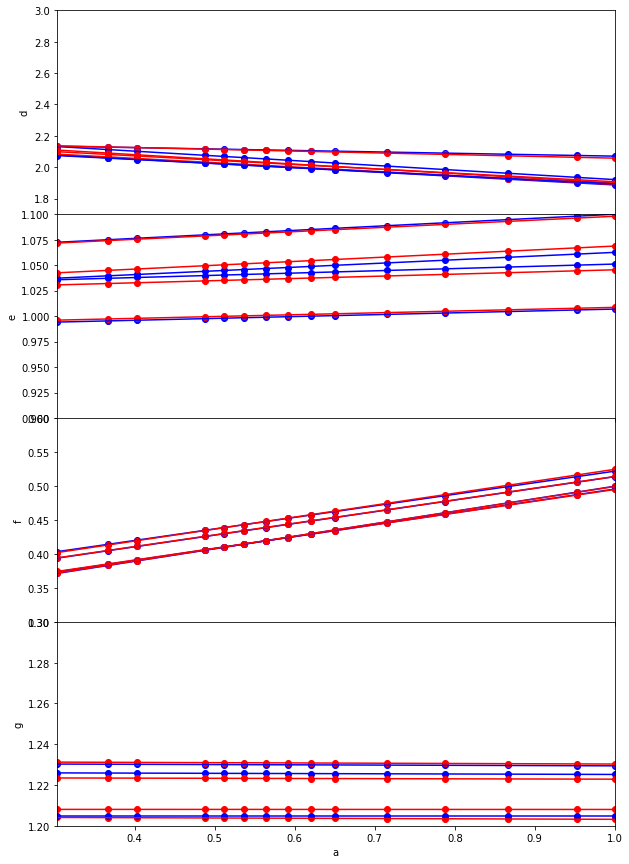

In [22]:

import matplotlib.pyplot as plt


fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(10,15), sharex=True)
wjat = ['Box_n50_0_1400', 'Box_n50_14_1400', 'Box_n50_33_1400', 'Box_n50_32_1400']
# wjat = [leave_out_box, 'Box98_1400']

# for box in [leave_out_box]:#, 'Box_n50_14_1400']:
# for box in [leave_out_box, 'Box98_1400', 'Box_n50_0_1400']:#, 'Box_n50_14_1400', 'Box_n50_33_1400', 'Box_n50_32_1400']:
for box in tqdm(wjat):
    curr_cosmo_vals = tuple(get_cosmo_vals(cosmo_params[box]))
    curr_ccl_cosmo = get_ccl_cosmology(curr_cosmo_vals)

    param_names = ['d','e','f','g']
    ndim = len(param_names)
    plt.subplots_adjust(wspace=0, hspace=0)

    params = {'d':[], 'e':[], 'f':[], 'g':[]}
    paramsEMU = {'d':[], 'e':[], 'f':[], 'g':[]}

    for a in a_list:
        R = 8 / (cosmo_params[box]['H0'] / 100)
        sigma8z = cosmo.sigmaR(R, a=a)
        EMU  = (Emulator.predict_params(cosmo_params[box], scaleToRedshift(a))) #, sigma8z))

        with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_params.pkl"%(box), "rb") as f:
            MLE_params = pickle.load(f)
            curr_params = list(MLE_params.values())
            paired_params = list(zip(curr_params, curr_params[1:]))[::2]

            param_at_z = {'d':-1, 'e':-1, 'f':-1, 'g':-1}

            for (p0,p1), key in zip(paired_params, param_at_z):
                param_at_z[key] = p(p0, p1, a)
            MLE_params = param_at_z

        for key in MLE_params:
            params[key] += [MLE_params[key]]
            paramsEMU[key] += [EMU[key]]


    for i, param in enumerate(params):
        aaaaa = 1
        axs[i].scatter(a_list, params[param], alpha=aaaaa, color='blue')
#         print(list(zip(a_list,params[param])))
#         print()
        axs[i].plot(a_list, params[param], alpha=aaaaa, color='blue')

        axs[i].scatter(a_list, paramsEMU[param], alpha=aaaaa, color='red')
        axs[i].plot(a_list, paramsEMU[param], alpha=aaaaa, color='red')

        axs[i].set_ylabel(param)
    #     axs[i].set_ylim([0,2])
        axs[i].set_xlim([min(a_list), 1])

axs[-1].set_xlabel('a')
# axs[0].set_ylim([0.25,.45])
# axs[1].set_ylim([0.29,.305])
# axs[2].set_ylim([1.4,1.8])
# axs[3].set_ylim([1.18, 1.2])
axs[0].set_ylim([1.7, 3.])
axs[1].set_ylim([0.9, 1.1])
axs[2].set_ylim([.3,.6])
axs[3].set_ylim([1.2,1.3])
# axs[0].set_title(box)

 13%|█▎        | 2/15 [00:01<00:06,  2.03it/s]

[2.176431529399106, 0.9947063284226549, 0.5223997355637658, 1.2280946927125096]
[2.190227106666656, 0.9920465270726675, 0.5156211396973251, 1.2280959592632104]


 27%|██▋       | 4/15 [00:01<00:02,  4.06it/s]

[2.2005296230109606, 0.986518110986079, 0.5031044857752947, 1.2280968566552486]
[2.211171980720938, 0.9820675763910434, 0.49139515483724217, 1.2289712235285868]


 40%|████      | 6/15 [00:01<00:01,  5.55it/s]

[2.2482770614623844, 0.9784624758389601, 0.4790715004220306, 1.231343584988881]
[2.2726128262734786, 0.9749410619320034, 0.4687160116997149, 1.233116788121964]


 53%|█████▎    | 8/15 [00:02<00:01,  4.16it/s]

[2.2855221364804215, 0.9731335523200331, 0.4632323803044346, 1.2341178305332958]
[2.3030270543056606, 0.9716345435254987, 0.45818954495021014, 1.235391047930531]


 67%|██████▋   | 10/15 [00:02<00:00,  5.78it/s]

[2.2981953662323304, 0.9699971918746875, 0.4546079273402134, 1.2353949291177413]
[2.3024563434387693, 0.9680053623176561, 0.45096080991384957, 1.2353959905161211]


 80%|████████  | 12/15 [00:02<00:00,  7.22it/s]

[2.3252978201077408, 0.9657442920088855, 0.44519057151649805, 1.2353962483944603]
[2.328566015615783, 0.9642856469515912, 0.4417436166664215, 1.2353978417595846]


 93%|█████████▎| 14/15 [00:02<00:00,  8.18it/s]

[2.345129637693377, 0.9581935732533614, 0.4270860045138749, 1.235398661636454]
[2.3812463962803223, 0.9542637373203032, 0.41742103814323583, 1.2353987371660835]
[2.359570419295517, 0.9521370129246526, 0.41326665811430197, 1.2354010962605466]


100%|██████████| 15/15 [00:03<00:00,  4.94it/s]


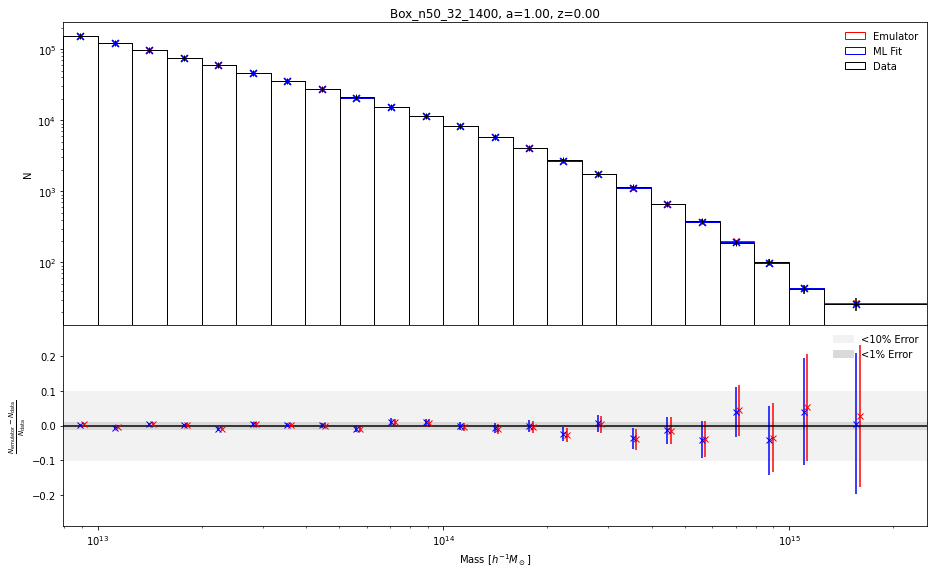

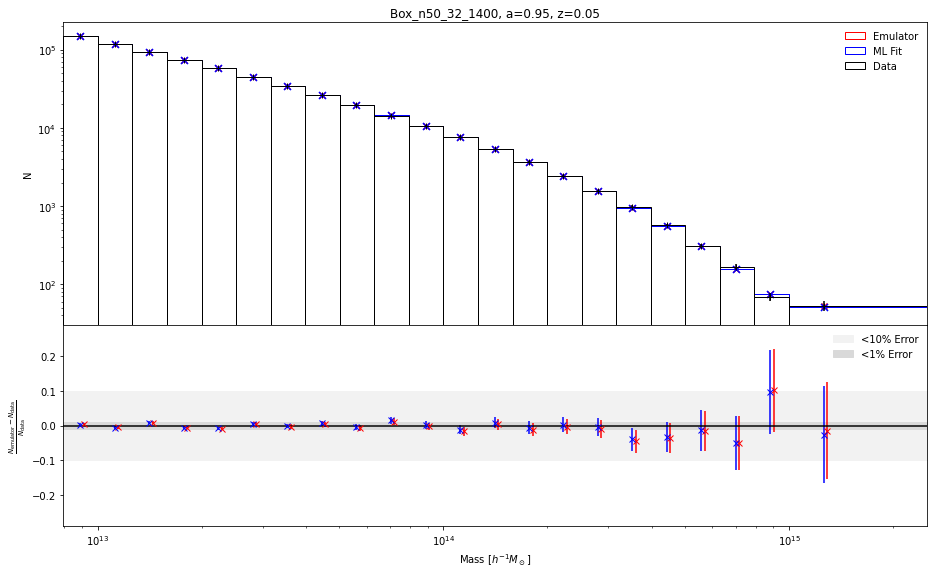

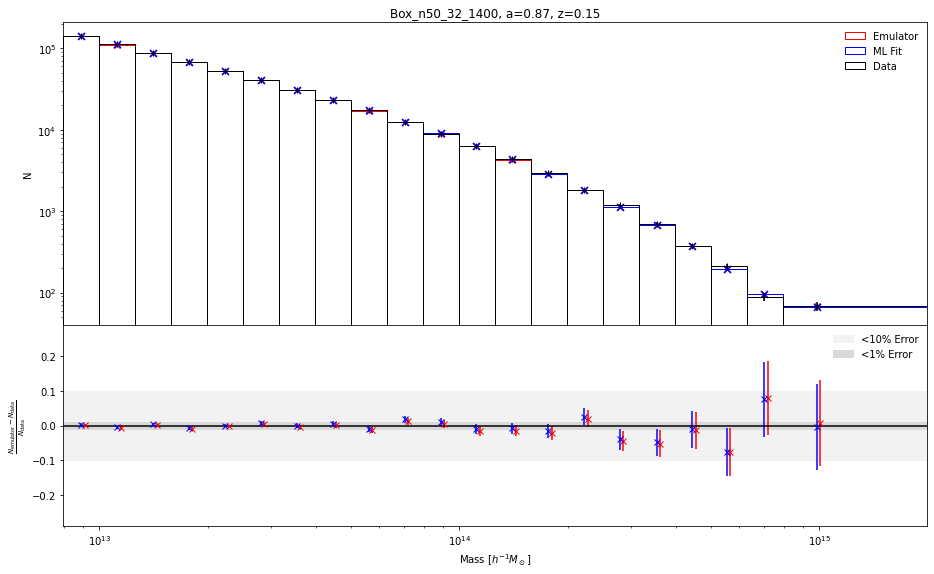

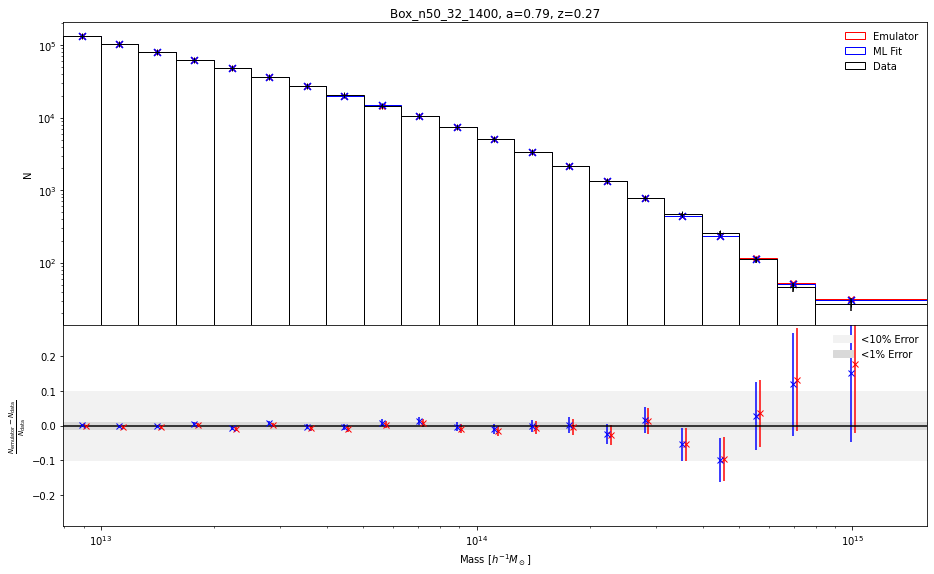

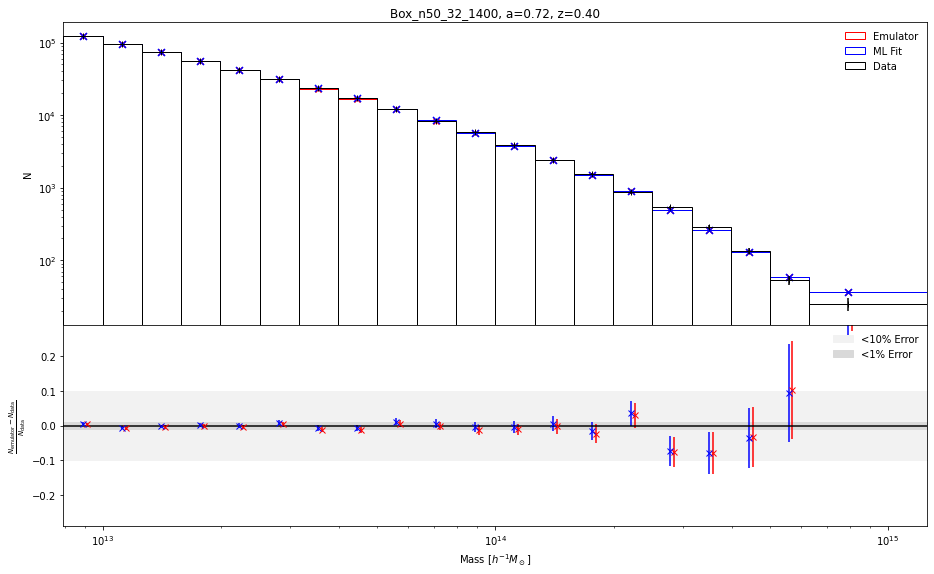

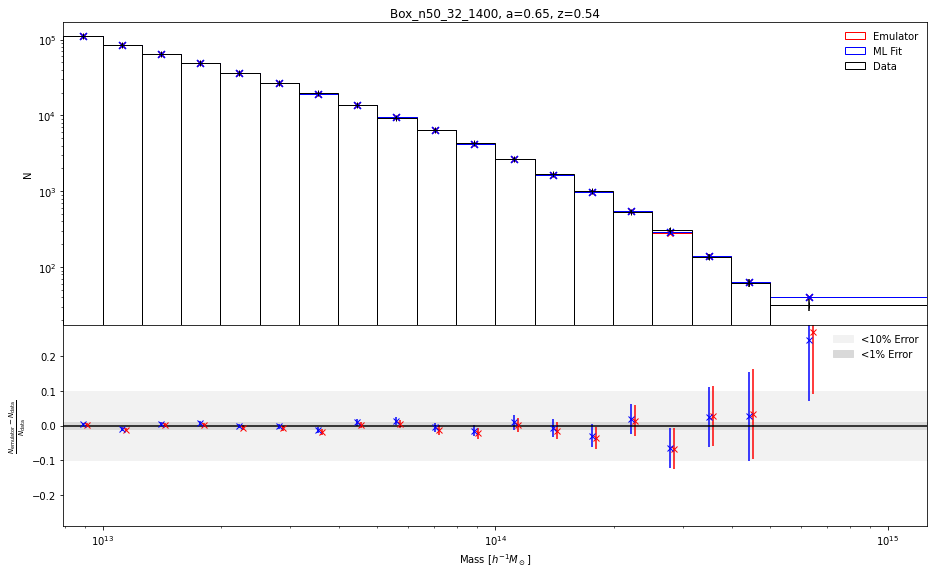

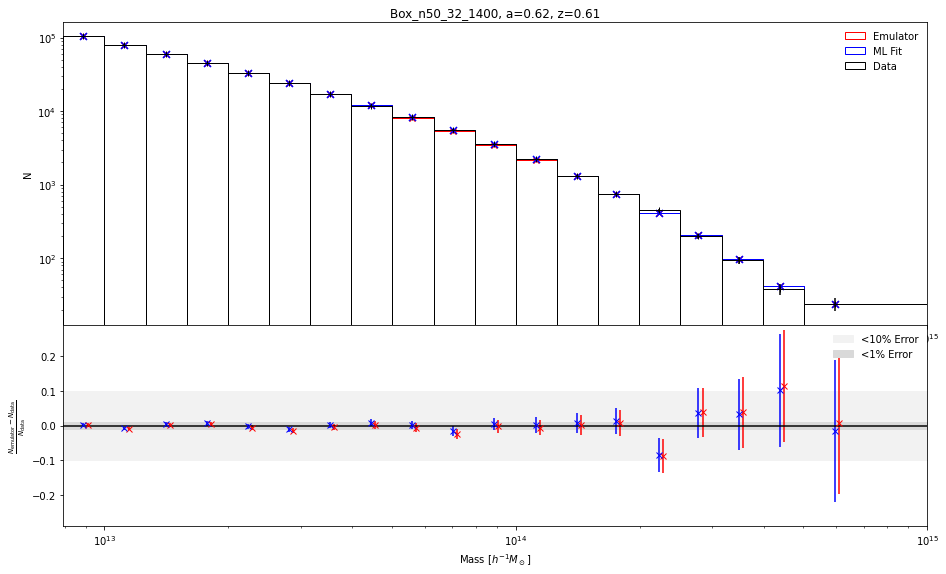

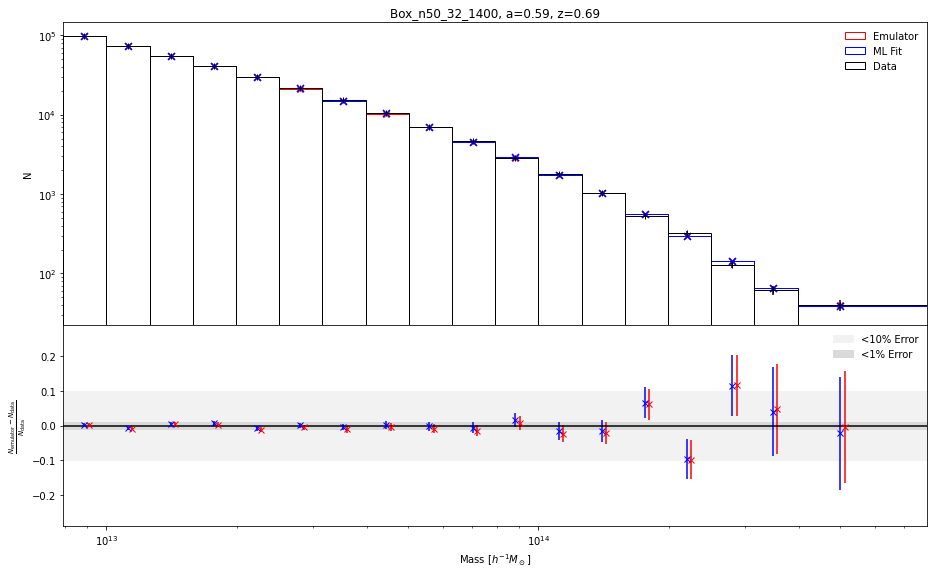

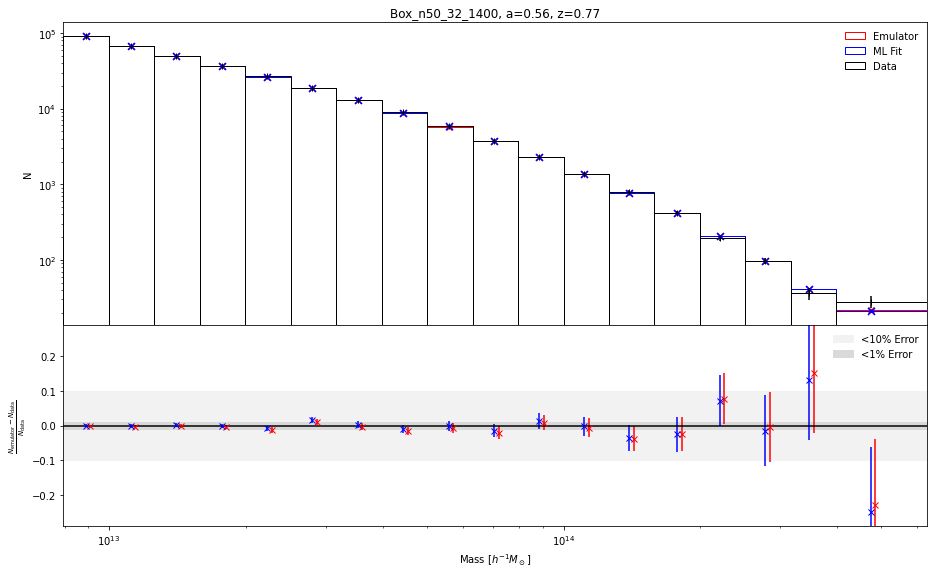

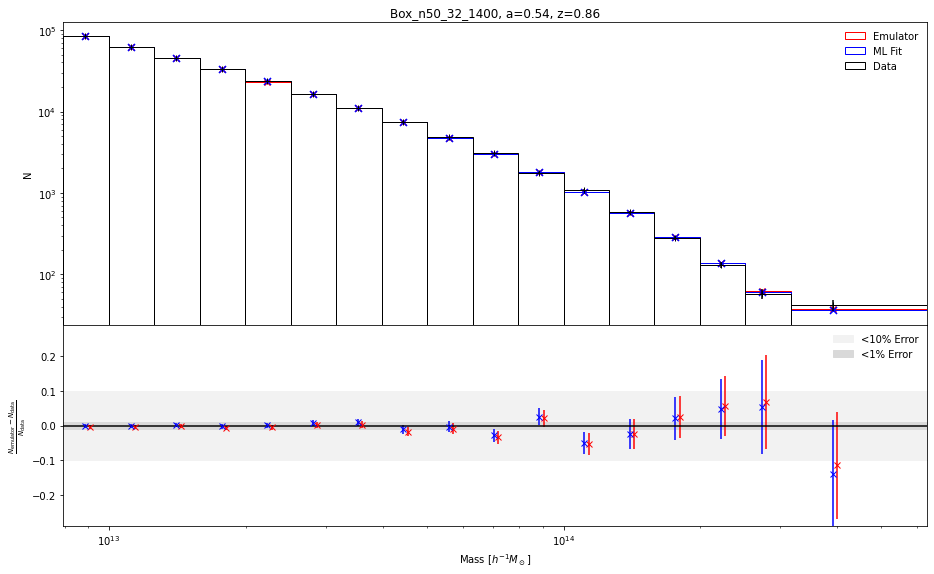

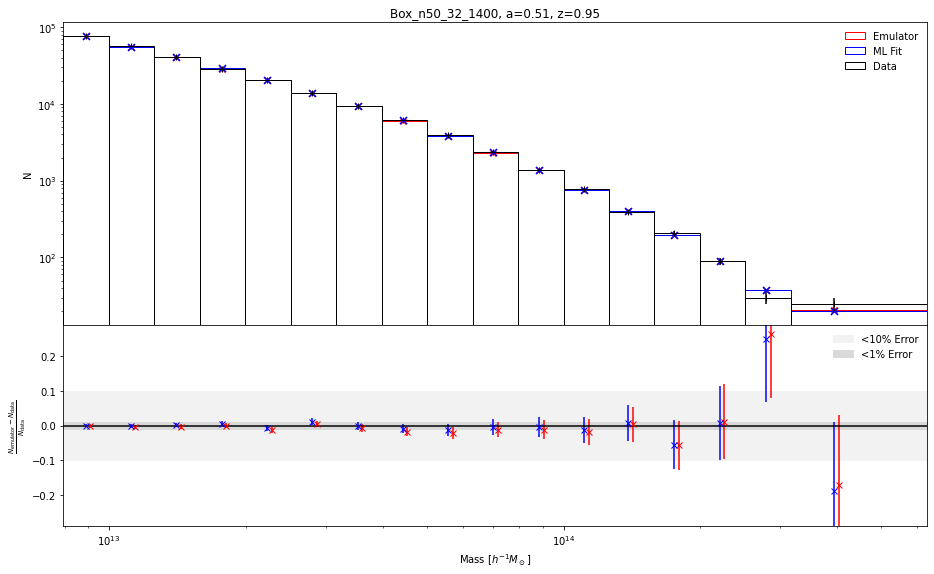

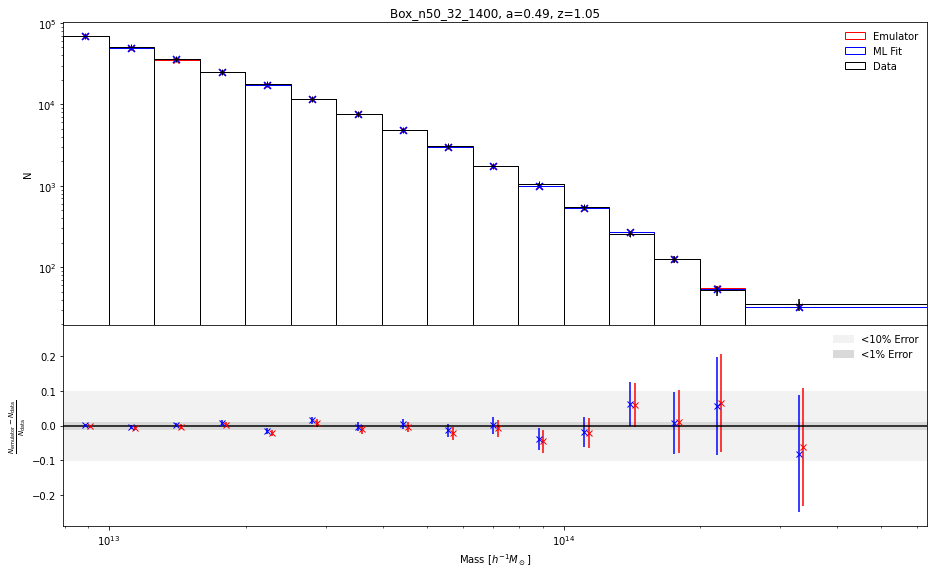

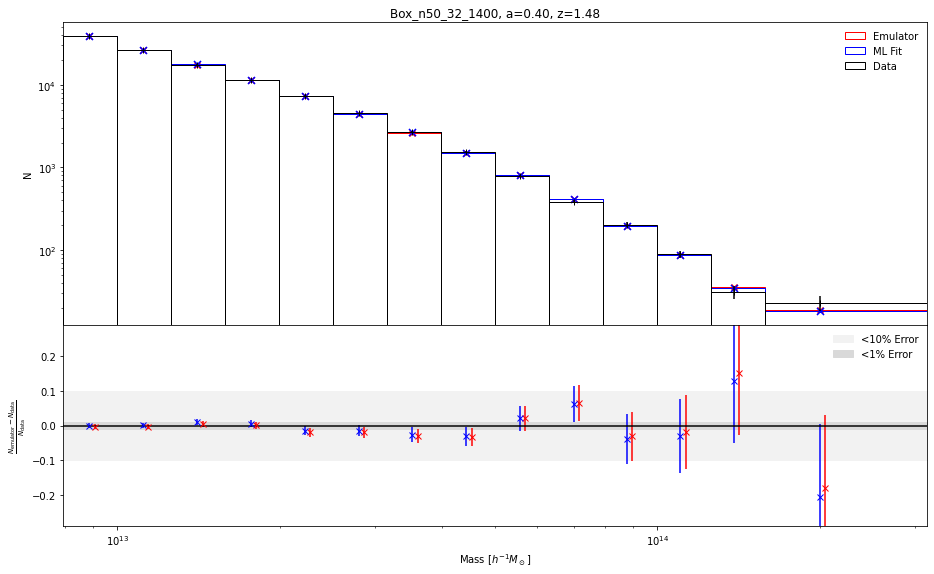

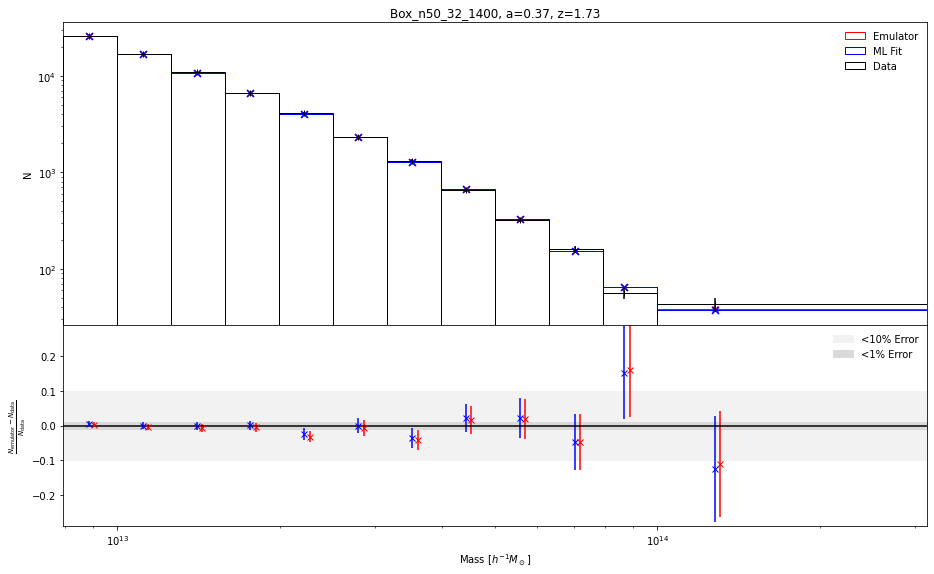

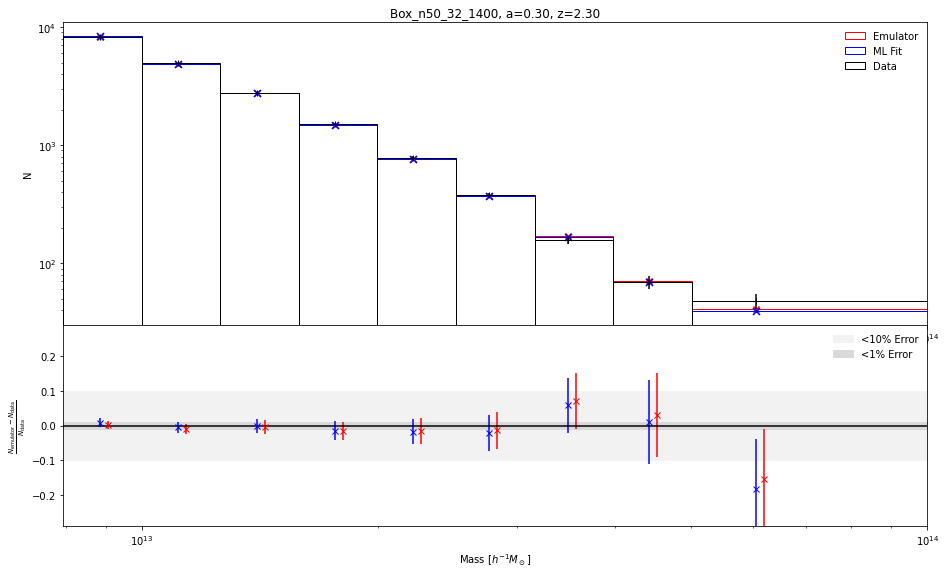

In [31]:
box = 'Box_n50_32_1400'

from aemulusnu_massfunction.massfunction import *

NvM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_NvsM.pkl'
NvM_f = open(NvM_fname, 'rb')
NvMs = pickle.load(NvM_f) #NvMs is a dictionary of dictionaries
NvM_f.close()

N_data = {}
M_data = {}
aux_data = {}

vol = -1 #Mpc^3/h^3
Mpart = -1

for a in tqdm(a_list):
#     if(a != 1): #TEST
#         continue
    c_data = NvMs[a]

    Ms = c_data['M'] #units of h^-1 Msolar
    N = c_data['N']
    edge_pairs = c_data['edge_pairs']
    assert(len(Ms) == len(edge_pairs))
    assert(len(Ms) == len(N))

    if(vol==-1):
        vol = c_data['vol']
    assert(vol == c_data['vol'])

    if(Mpart==-1):
        Mpart = c_data['Mpart']
    assert(Mpart == c_data['Mpart'])

    N_data[a] = []
    M_data[a] = []
    aux_data[a] = []
    for N_curr, M_curr, edge_pair in zip(N, Ms, edge_pairs):
        N_data[a] += [N_curr]
        M_data[a] += [M_curr]
        aux_data[a] += [{'a':a, 'edge_pair':edge_pair}]
M_numerics = np.logspace(np.log10(100*Mpart), 16, 50)

jackknife_covs_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_jackknife_covs.pkl'
jackknife_covs_f = open(jackknife_covs_fname, 'rb')
jackknife = pickle.load(jackknife_covs_f)
jackknife_covs_f.close()

jack_covs = {a:jackknife[a][1] for a in N_data}

# Compute the weighted covariance matrix incorporating jackknife and poisson
weighted_cov = {a: jack_covs[a] for a in jack_covs}

param_names = ['d','e','f','g']


true_params = {}

ccl_cosmo = get_ccl_cosmology(tuple(get_cosmo_vals(cosmo_params[box])))

h = cosmo_params[box]['H0']/100


for a in tqdm(a_list):
    yerr = np.sqrt(np.diagonal(weighted_cov[a]))
    fig1 = plt.figure(figsize =(12, 7))

    axs=[fig1.add_axes((0.0,0.4,1,.6)), fig1.add_axes((0.0,0.0,1,.4))]
    plt.subplots_adjust(wspace=0, hspace=0)
    c_data = NvMs[a]

    Ms = M_data[a]
    N = N_data[a]
    edge_pairs = c_data['edge_pairs']

    edges = [edge[0] for edge in edge_pairs]
    edges += [edge_pairs[-1][1]]

    #shade in 1% and 10% error region
    edges = np.array(edges)
    
    

    y1 = 0.1*np.ones_like(N)
    y1 = np.append(y1, y1[-1])
    y1 = np.append(y1[0], y1)

    y2 = -0.1*np.ones_like(N)
    y2 = np.append(y2, y2[-1])
    y2 = np.append(y2[0], y2)

    c_Ms = np.append(Ms, edges[-1])
    c_Ms = np.append(edges[0], c_Ms)
    axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.95',label='<10% Error')

    y1 = 0.01*np.ones_like(N)
    y1 = np.append(y1, y1[-1])
    y1 = np.append(y1[0], y1)

    y2 = -0.01*np.ones_like(N)
    y2 = np.append(y2, y2[-1])
    y2 = np.append(y2[0], y2)

    axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.85',label='<1% Error')


    dM = np.array([edges[1]-edges[0] for edges in edge_pairs])


    #Emulator 
    f_dNdM_MCMC =  lambda M:Emulator(ccl_cosmo, M/h, a)*vol/(h**3 * M * np.log(10)) # h / Msun
    tinker_eval_MCMC = np.array([quad(f_dNdM_MCMC, edge[0],  edge[1], epsabs=0, epsrel=1e-5)[0] for edge in edge_pairs])

    axs[0].scatter(Ms, tinker_eval_MCMC, marker='x', c='red')
    axs[0].bar(x=edges[:-1], height=tinker_eval_MCMC, width=np.diff(edges),
               align='edge', fill=False, ec='red', label='Emulator')
    with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_NvMemulator_loo_output.pkl"%(box, a), "wb") as f:
        pickle.dump({'Ms':Ms, 'tinker_eval':tinker_eval_MCMC, 'N':N, 'edges':edges}, f)

    tmp = np.array([c_tmp*10**(0.01)-c_tmp for c_tmp in Ms])
    axs[1].errorbar(Ms + tmp, (tinker_eval_MCMC-N)/N, yerr/N, fmt='x', color='red')

    #ML Fit

    mass_function = MassFuncAemulusNu_fitting()
    
    with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_params.pkl"%(box, a), "rb") as f:
        MLE_params = pickle.load(f)
        print(list(MLE_params.values()))
        mass_function.set_params(list(MLE_params.values()))


    f_dNdM_MCMC =  lambda M:mass_function(ccl_cosmo, M/h, a)*vol/(h**3 * M * np.log(10)) # h / Msun
    tinker_eval_MCMC = np.array([quad(f_dNdM_MCMC, edge[0],  edge[1], epsabs=0, epsrel=1e-5)[0] for edge in edge_pairs])
    axs[0].scatter(Ms, tinker_eval_MCMC, s=50 , marker='x', c='blue')
    axs[0].bar(x=edges[:-1], height=tinker_eval_MCMC, width=np.diff(edges), 
               align='edge', fill=False, ec='blue', label='ML Fit')
    axs[1].errorbar(Ms, (tinker_eval_MCMC-N)/N, yerr/N, fmt='x', color='blue')



    #Data
    axs[0].bar(x=edges[:-1], height=N, width=np.diff(edges),
           align='edge', fill=False, ec='black', label='Data')
    axs[0].errorbar(Ms, N, yerr, fmt='+', c='black')

    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].legend(frameon=False)
    axs[0].set_ylabel('N')

    axs[1].set_xscale('log')
    # axs[1].set_yscale('lin', linthresh=1e-2)    
    axs[1].legend(frameon=False)
    axs[1].axhline(0, c='black')
    axs[1].set_ylabel('N')
    axs[1].set_xlabel(r'Mass $[h^{-1}M_\odot]$')
    axs[1].set_ylabel(r'$\frac{N_{\rm emulator}-N_{\rm data}}{N_{\rm data}} $')
    axs[0].set_title('%s, a=%.2f, z=%.2f'%(box, a, scaleToRedshift(a)))

    left = np.ceil(np.log10(200*Mpart) * 10) / 10
    axs[0].set_xlim((10**left, np.max(edges)))
    axs[1].set_xlim((10**left, np.max(edges)))
    axs[1].set_ylim((-.29, .29))
    axs[1].set_yticks([-.2, -.1, 0, .1, .2])

#     plt.savefig('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/emulator/%s_emufit_%.2f.pdf'%(box, a), bbox_inches='tight')